In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

In [2]:
%run ./engine_gandalf_wintermute.py
%run ./functions_gandalf_wintermute.py
%run ./Genetic_Lib.ipynb

5.13.1


### CARICO DATI

In [6]:
from tqdm.notebook import tqdm
import talib as ta


def PF3up(df,cnt):
    df['MA3'] = ta.SMA(df['close'].values,3)
    df['MA10'] = ta.SMA(df['close'].values,10)
    df['310Fast'] = df['MA3'] - df['MA10']
    df['310Slow'] = ta.SMA(df['310Fast'].values,16)
    df['ROC'] = ta.ROC(df['close'].values,2)
    df['PF3up'] = [True if (roc > roc1 and F > F1 and S > S1)  else False for roc,roc1,F,F1,S,S1 in zip(df['ROC'],df['ROC'].shift(1),df['310Fast'],df['310Fast'].shift(1),df['310Slow'],df['310Slow'].shift(1))]
    df.drop('MA3',axis=1,inplace=True)
    df.drop('MA10',axis=1,inplace=True)
    df.drop('310Fast',axis=1,inplace=True)
    df.drop('310Slow',axis=1,inplace=True)
    df.drop('ROC',axis=1,inplace=True)
    
    return df['PF3up']

def PF3down(df,cnt):
    df['MA3'] = ta.SMA(df['close'].values,3)
    df['MA10'] = ta.SMA(df['close'].values,10)
    df['310Fast'] = df['MA3'] - df['MA10']
    df['310Slow'] = ta.SMA(df['310Fast'].values,16)
    df['ROC'] = ta.ROC(df['close'].values,2)
    df['PF3down'] = [True if (roc < roc1 and F < F1 and S < S1)  else False for roc,roc1,F,F1,S,S1 in zip(df['ROC'],df['ROC'].shift(1),df['310Fast'],df['310Fast'].shift(1),df['310Slow'],df['310Slow'].shift(1))]
    df.drop('MA3',axis=1,inplace=True)
    df.drop('MA10',axis=1,inplace=True)
    df.drop('310Fast',axis=1,inplace=True)
    df.drop('310Slow',axis=1,inplace=True)
    df.drop('ROC',axis=1,inplace=True)

    return df['PF3down']


def MACD(dataset,period,direzione):
    macd, macd_signal, macd_hist = ta.MACD(dataset["close"], fastperiod=period, slowperiod=int(period*2.2), signalperiod=int(period*0.8))
    macd_signal = ta.WMA(macd,period)
    macd_signal = ta.SMA(macd,period)
    if direzione == 1:
        return  (macd-macd_signal)<0
    if direzione == -1:
        return  (macd-macd_signal)>0
    
def STOCH(dataset,period,direzione):
    slowk , slowd = ta.STOCH(dataset["high"], dataset["low"], dataset["close"], period, int(period*0.3), 0, int(period*0.25), 0)
    if direzione == 1:
        return  slowk>slowd
    if direzione == -1:
        return  slowk<slowd
    
def RSI_ctr(dataset,period,level,direzione):
    rsi = ta.RSI(dataset["close"],period)
    if direzione == 1:
        return  (rsi.shift(1)<(50+level))&(rsi>(50+level))
    if direzione == -1:
        return  (rsi.shift(1)>(50-level))&(rsi<(50-level))

def RSI_tr(dataset,period,level,direzione):
    rsi = ta.RSI(dataset["close"],period)
    if direzione == 1:
        return  (rsi.shift(1)<(50-level))&(rsi>(50-level))
    if direzione == -1:
        return  (rsi.shift(1)>(50+level))&(rsi<(50+level))
    
def hour_condition(dataset,hour,cnt):
     return dataset.index.hour==hour
  
    
def dayofweek_condition(dataset,dayofweek,cnt):
    return dataset.index.dayofweek==dayofweek

def day_condition(dataset,day,cnt):
    return dataset.index.day==day
  
    
def month_condition(dataset,month,cnt):
    return dataset.index.month==month


    
def apply_indicator(history):
    
    step_hour = list(set(history.index.hour))[1]-list(set(history.index.hour))[0]
    
    dow_list=[]
    for e in range(0,5):
        for i in range(11): ### numero di ripetizioni
            dow_list.append(eval('"(dayofweek_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            dow_list.append(eval('"(~dayofweek_condition(dataset,"+str(e)+","+str(i)+"))"'))
        
    hor_list=[]
    for e in range(0,24,step_hour): 
        for i in range(11): ### numero di ripetizioni
            hor_list.append(eval('"(hour_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            hor_list.append(eval('"(~hour_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            
            
    day_list=[]
    for e in range(1,32):
        for i in range(5): ### numero di ripetizioni
            day_list.append(eval('"(day_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            day_list.append(eval('"(~day_condition(dataset,"+str(e)+","+str(i)+"))"'))
        
    month_list=[]
    for e in range(1,13):
        for i in range(6): ### numero di ripetizioni
            month_list.append(eval('"(month_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            month_list.append(eval('"(~month_condition(dataset,"+str(e)+","+str(i)+"))"'))         
            
            
        
    macd_list=[]
    for e in range(3,51):
        macd_list.append(eval('"(MACD(dataset,"+str(e)+",1))"'))   
        macd_list.append(eval('"(MACD(dataset,"+str(e)+",-1))"'))  
            
    stoch_list=[]
    for e in range(6,51):
        stoch_list.append(eval('"(STOCH(dataset,"+str(e)+",1))"'))   
        stoch_list.append(eval('"(STOCH(dataset,"+str(e)+",-1))"'))  
        
    rsi_list = []
    for e in range(5,30): ## periodi 
        for i in range(5,45,5): ##livelli
            rsi_list.append(eval('"(RSI_ctr(dataset,"+str(e)+","+str(i)+",1))"'))   
            rsi_list.append(eval('"(RSI_ctr(dataset,"+str(e)+","+str(i)+",-1))"'))
            rsi_list.append(eval('"(RSI_tr(dataset,"+str(e)+","+str(i)+",1))"'))   
            rsi_list.append(eval('"(RSI_tr(dataset,"+str(e)+","+str(i)+",-1))"'))
            
    pf3_list=[]
    for i in range(11):
        pf3_list.append(eval('"(PF3up(dataset,"+str(i)+"))"')) 
        pf3_list.append(eval('"(PF3down(dataset,"+str(i)+"))"')) 
        
        
    lista_rules=[]
    lista_indicatori=[macd_list,stoch_list,dow_list,hor_list] #macd_list,stoch_list,rsi_list ,stoch_listmacd_list ,month_list
    
    tmp_df = dataset.close.to_frame()
    
    for i in tqdm(lista_indicatori):
        print(len(i))
        for e in i:
            tmp_check=eval(e)
            if (tmp_check.sum()>10)&(tmp_check.sum()<len(tmp_check)):
                tmp_df[e]=tmp_check
    tmp_df.drop(["close"],axis=1,inplace=True)
    return  tmp_df , tmp_df.columns.to_list() 


In [7]:
####################### pattern

dataset["dayofweek"] = dataset.index.dayofweek
dataset["day"] = dataset.index.day
dataset["week"] = dataset.index.week
dataset["month"] = dataset.index.month
dataset["year"] = dataset.index.year
dataset["dayofyear"] = dataset.index.dayofyear
dataset["quarter"] = dataset.index.quarter
dataset["hour"] = dataset.index.hour
dataset["minute"] = dataset.index.minute
dataset["daily_open"] = daily_open(dataset,1)
dataset["daily_high"] = daily_high(dataset,1)
dataset["daily_low"] = daily_low(dataset,1)
dataset["daily_close"] = daily_close(dataset,1)

def eval_pattern(ptn):
    for e in ptn:
        exec(e,data)

def apply_indicator(dataset):

    data=dataset.copy()
    
    ptn=pattern_translator()
    ptn_list = []
    for e in tqdm(range(1,len(ptn))):
        for r in ptn["p"+str(e)]:
            exec(r)
        ptn_list.append("p"+str(e))
    data = dataset[ptn_list]  
    for i in data.columns:
        data[i+"_not"] = ~data[i]
        dataset[i+"_not"] = ~dataset[i]
        
        
    dow_list=[]
    for e in range(0,5):
        for i in range(11): ### numero di ripetizioni
            a=(eval('"(dayofweek_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            b=(eval('"(~dayofweek_condition(dataset,"+str(e)+","+str(i)+"))"'))
            dataset[a]=eval(a)
            dataset[b]=eval(b)
            data[a]=eval(a)
            data[b]=eval(b)
    hor_list=[]
    for e in range(0,24,4): 
        for i in range(11): ### numero di ripetizioni
            a=(eval('"(hour_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            dataset[a]=eval(a)
            data[a]=eval(a)
    return data , data.columns

In [8]:
%time rules, rule_formulas = apply_indicator(dataset)
print(len(rule_formulas))

  0%|          | 0/149 [00:00<?, ?it/s]

Wall time: 2.64 s
474


In [9]:
import os
os.chdir(r"C:\Users\Drako\MLA04_Evolutionary_Algorithms\Python_Code")
%run ./Genetic_Lib.ipynb

In [10]:
def plot_equity_GSA(dna):
    
    gains = all_gains_full(dna)
    if GSA == 1:
        ls_os = np.array_split(gains,GSA_SPLIT)[1::2]
        if len(ls_os)>1:
            l_lst=[]
            for nls in ls_os:
                l_lst.append([nls[0][0],nls[-1][0]])
            for ln in range(len(l_lst)):
                #if ln != len(l_lst)-1:
                a2,a2b=l_lst[ln][0], l_lst[ln][-1]
                plt.axvspan(a2,a2b,alpha=0.2, color='red',label ="")
    if len(gains)>0:
        times, gains = zip(*gains)
        profits = np.array(gains).cumsum()
        equity = pd.Series(profits, times)
        equity.plot(figsize=(14, 8), grid = True, label="main strategies")
        plt.axvline(x=OOS_date ,color="red")


"""def all_gains(dna):
    
    rule = setups(numba.typed.List(dna))
    rule.setflags(write=1)
    rule=rule[:Out_Of_Sample_pct]
    gains = numba_engine(rule,TIME_EXIT,gains_array[:Out_Of_Sample_pct],COSTS_FIXED)
    tmp_times_array = times_array[:Out_Of_Sample_pct]
    ls=[]
    for e in range(len(gains)):
        if gains[e]!=0:
            ls.append([tmp_times_array[e],gains[e]])
    if INSTABILITY_FACTOR>0:
        ls = instability(ls,INSTABILITY_FACTOR)
    if GSA == 1:
        ls_is , ls_os =fast_GSA(ls,GSA_SPLIT)
        if len(ls_is)>1:
            ls=merge_lst(ls_is)            
    return ls"""

def OOS(dataset,pct):
    if pct == 0:
        return len(dataset)
    else:
        return int(len(dataset) - (len(dataset) // (100/pct)))
    
def instability(array,pct):
    dimension = int(len(array) - (len(array) // (100/pct)))
    rng = np.random.default_rng()
    rand_array=rng.choice(array, dimension)
    return np.array(sorted(sorted(rand_array,key=lambda e:e[1]),key=lambda e:e[0]))

def fast_GSA(dataframe,n_split):
    newdf_split = np.array_split(dataframe, n_split)
    return np.concatenate(newdf_split[0::2]) , np.concatenate(newdf_split[1::2])

def merge_lst(a):
    import collections
    super_dict = collections.defaultdict(list)
    for e in a:
        super_dict[e[0]].append(e[1])
    dictlist=list()
    for key, value in super_dict.items():
        dictlist.append([key]+value)
    return dictlist


def plot_equity_full(dna,secondary_equity):
    """
    Funzione che grafichi l'equity line risultatnte 
    dato un DNA.
    """
    gains = all_gains_full(dna)
    if len(gains)>0:
        gains=stack_sort(gains,secondary_equity)
        times, gains = zip(*gains)
        profits = np.array(gains).cumsum()
        equity = pd.Series(profits, times)
        equity.plot(figsize=(14, 8), grid = True, color="green")
        dataset.close.plot(secondary_y=True,color="grey",linewidth=0.3)
        plt.axvline(x=OOS_date ,color="red")

In [11]:
def Shift(rule):
    return list(pd.Series(rule).shift(1 , fill_value=False).values)

def all_gains(dna):
    rule = setups(numba.typed.List(dna))
    rule = Shift(rule)
    cond=rule[:Out_Of_Sample_pct]
    ls = new_engine(TIME_EXIT,START_SESSION,END_SESSION,cond,cond_idx,cond_date,price,DIRECTION,COSTS_FIXED) 
    if INSTABILITY_FACTOR>0:
        ls = instability(ls,INSTABILITY_FACTOR)
    if GSA == 1:
        ls_is , ls_os =fast_GSA(ls,GSA_SPLIT)
        if len(ls_is)>1:
            ls=merge_lst(ls_is)            
    return ls

def all_gains_full(dna):   
    rule = setups(numba.typed.List(dna))
    rule = Shift(rule)
    ls = new_engine(TIME_EXIT,START_SESSION,END_SESSION,rule,cond_idx,cond_date,price,DIRECTION,COSTS_FIXED)
    return ls

def new_engine(TIME_EXIT,START_SESSION,END_SESSION,cond,cond_idx,cond_date,price,DIRECTION,COSTS_FIXED):  #### motore backtest genetico x end of day
    operations=[]
    date_ls=[]
    last=0
    for first in np.where(cond)[0]:
        if first > last:
            if (cond_idx[first] >= START_SESSION)&(cond_idx[first] <= END_SESSION):
                if (cond_idx[first]+TIME_EXIT)<END_SESSION:
                    if (first+TIME_EXIT)>len(price):
                        tmp_price_idx=len(price)
                    else:
                        tmp_price_idx = first+TIME_EXIT
                    operation = (price[first+TIME_EXIT]-price[first])*BIGPOINTVALUE
                    if DIRECTION == "short":
                        operation = operation*(-1)
                    operations.append([cond_date[first],operation-COSTS_FIXED])
                    last=first+TIME_EXIT
                else:
                    TIME_EXIT_EOD = END_SESSION-cond_idx[first]
                    if (first+TIME_EXIT_EOD)>len(price):
                        tmp_price_idx=len(price)
                    else:
                        tmp_price_idx = first+TIME_EXIT_EOD                    
                    operation = (price[first+TIME_EXIT_EOD]-price[first])*BIGPOINTVALUE
                    if DIRECTION == "short":
                        operation = operation*(-1)
                    operations.append([cond_date[first],operation-COSTS_FIXED])  
                    last=first+TIME_EXIT_EOD  
    return operations

def stack_sort(gains,secondary_equity):
    if len(secondary_equity)>2:
        c=np.vstack((gains,secondary_equity))  
        d=sorted(c,key=lambda x: x[0])
        return d
    else:
        return gains
    
def secondary_OOS(secondary_equity ,OOS_date):
    if len(secondary_equity )>2:
        return[e for e in secondary_equity  if e[0] < OOS_date]
    else:
        return secondary_equity 

In [58]:
last_dna = best_dnas[-1]

In [59]:
secondary_equity = all_gains_full(last_dna)

In [46]:
secondary_equity = []

('generation', 19, ':', 4.19, ' ', '(p45_not) & (p129_not) & ((~dayofweek_condition(dataset,1,4))) & (p100_not)')


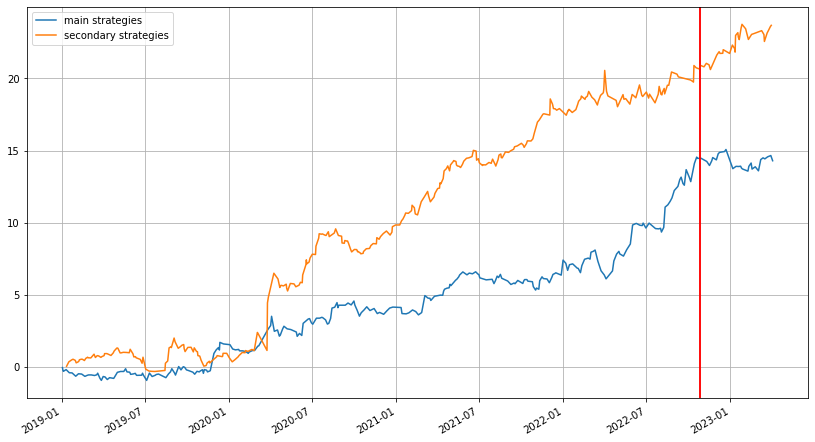

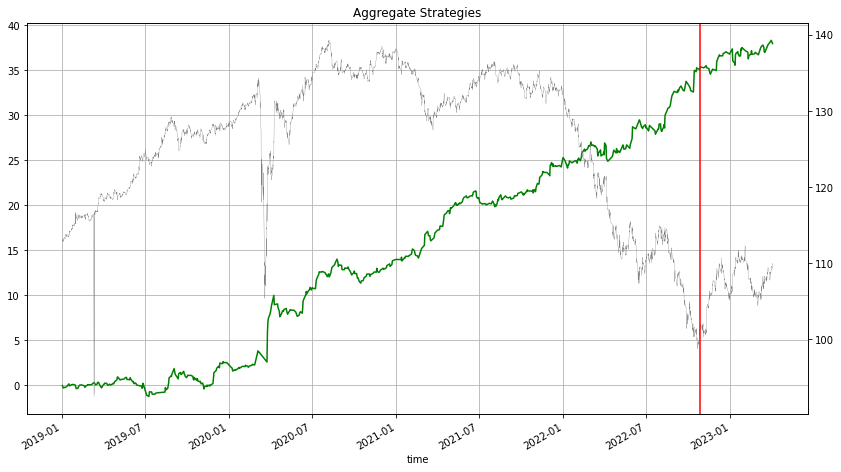

Wall time: 39.4 s


In [60]:
INSTRUMENT = 2  # 1: equity, 2: future, 3: crypto/forex
CAPITAL = 1  # money per trade (case INSTRUMENTS = 1,3) or number of contracts (case INSTRUMENTS = 2)
BIGPOINTVALUE = get_poin_values(path,simbolo)
TICK = 0.0001
COSTS_FIXED = 0
Out_Of_Sample_pct = OOS(dataset,10)
secondary_equity = check_secondary_equity(secondary_equity)

START_SESSION = 17
END_SESSION = 22
TIME_EXIT = 40
DIRECTION = "short"

POPULATION_SIZE = 300
NUM_GENERATIONS = 20

DNA_SIZE = 4
BEST_DNA_RATIO = 0.2
CROSS_DNA_RATIO = 0.2
MUTATION_PROB = 0.5

# Profit
# AvgTrade
# ProfitFactor
# GrossProfit
# Profit/MaxDrawDown
# AvgTrade/MaxDrawDown
# KestnerRatio
# StandardDeviation
# SQN
FITNESS_FUNCTION = "SQN"
MIN_OPERATIONS = 200

INSTABILITY_FACTOR = 0
GSA = 0
GSA_SPLIT = 5

# Conversioni per Numba
rules_array = rules.copy().values.T
cond_idx = rules.index.hour.values
cond_date = rules.index.values
price = dataset.open 

population = first_generation()

OOS_date = dataset.iloc[:Out_Of_Sample_pct].index[-1]

%time best_dnas = evolution()

<AxesSubplot:title={'center':'Log - evolution of metrics  '}>

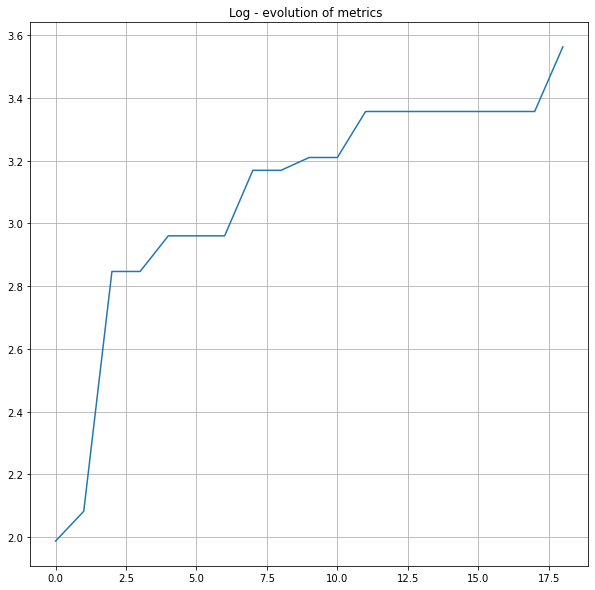

In [48]:
log_metric = pd.Series(log)
log_metric.plot(grid=True,figsize=(10,10),title="Log - evolution of metrics  ")

In [49]:
df_operations = pd.DataFrame()
#INSTABILITY_FACTOR =0
for e in range(len(best_dnas)):
    x=all_gains(best_dnas[e])
    times, gains = zip(*x)
    y=pd.Series(index=times,data=gains)
    y=y.to_frame()
    y.columns=(["Generazione_"+str(e)])
    y=y.resample("D").sum()
    df_operations=pd.concat([df_operations,y],axis=1).fillna(0)


<AxesSubplot:>

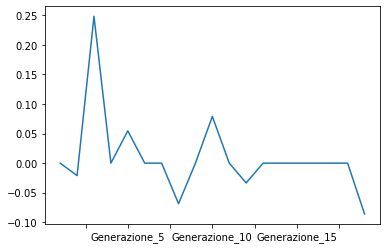

In [50]:
a=df_operations.corr().iloc[:,0]
b=a[a!=a.shift(1)].index.to_list()
df_operations.corr().sum().pct_change().plot()

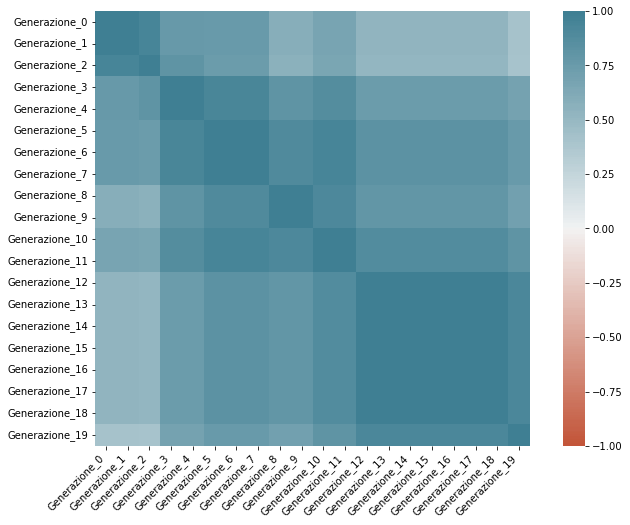

In [51]:
import matplotlib.pyplot as plt

corr=df_operations.corr()

import seaborn as sns
%matplotlib inline
plt.figure(figsize=[12,8])
# plot the heatmap
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [52]:
df_operations[b].resample("D").sum().corr()

,Generazione_0,Generazione_2,Generazione_3,Generazione_5,Generazione_8,Generazione_10,Generazione_12,Generazione_19
Generazione_0,1.000000,0.937659,0.763028,0.753904,0.582127,0.679652,0.533306,0.420708
Generazione_2,0.937659,1.000000,0.813789,0.735297,0.562518,0.654517,0.510359,0.404281
Generazione_3,0.763028,0.813789,1.000000,0.930597,0.818631,0.872314,0.740675,0.679988
Generazione_5,0.753904,0.735297,0.930597,1.000000,0.888078,0.943606,0.821704,0.752894
Generazione_8,0.582127,0.562518,0.818631,0.888078,1.000000,0.913347,0.789665,0.704504
Generazione_10,0.679652,0.654517,0.872314,0.943606,0.913347,1.000000,0.876475,0.806904
Generazione_12,0.533306,0.510359,0.740675,0.821704,0.789665,0.876475,1.000000,0.920725
Generazione_19,0.420708,0.404281,0.679988,0.752894,0.704504,0.806904,0.920725,1.000000


<AxesSubplot:>

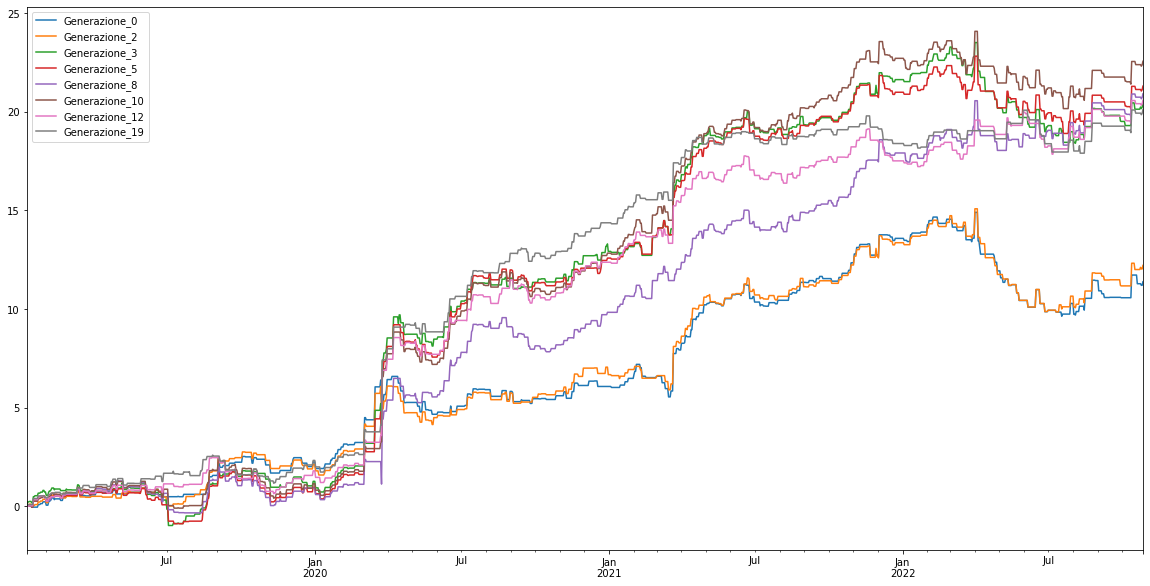

In [54]:
df_operations[b].cumsum().plot(figsize=(20,10))

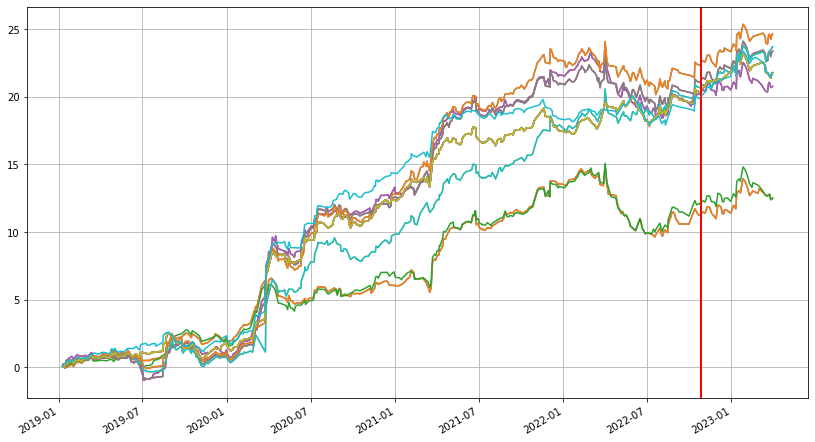

In [55]:
for el in best_dnas:
    plot_equity(el)

In [56]:
# stampa la fitness del miglior DNA dell'ultima generazione
last_dna = best_dnas[8]
fitness(last_dna)

3.169134349804274

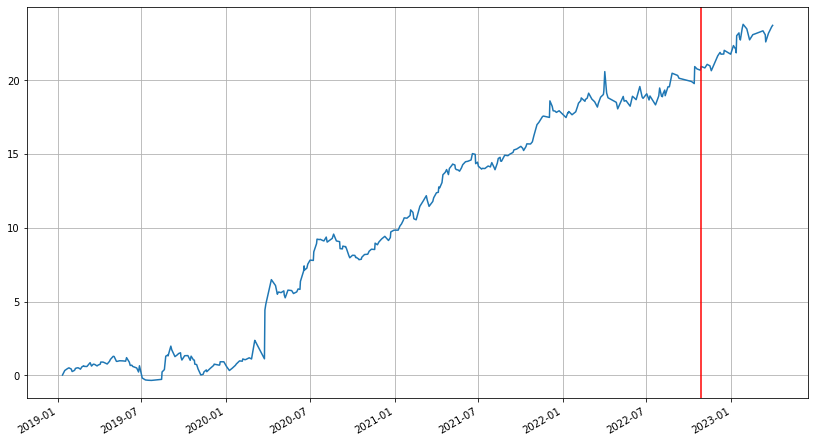

In [57]:
plot_equity(last_dna)

In [168]:
len(all_gains(last_dna))

292

In [186]:
def pattern_formula(last_dna):
    regola = dna_formula(last_dna)
    regola=regola.replace("p","dataset.p")
    return regola


Elaboration starting at: 2023-04-02 12:13:41.642259
Elaboration completed at: 2023-04-02 12:13:41.652267 in 0:00:00.010008

Consistency check: entries: 274 exits: 274

*****************************************************************************************
*** Performance Report - by Gandalf Project R&D - Version Wintermute - Copyright 2022 ***
*****************************************************************************************

CAGR:                     0.3 (capital = 100000)
Annual Return:            0.3 (capital = 100000)

Calmar Ratio:             0.67 (yearly)
Sharpe Ratio:             0.24 (initial capital = 100000, risk free rate = 0.0)
Sortino Ratio:            0.05 (initial capital = 100000, risk free rate = 0.0)
Omega Ratio:              0.32 (threshold = 100)
Kestner Ratio:            0.24

Operations:               274

Profit:                   1488.0
Average Trade:            5.43

Profit Factor:            1.07
Gross Profit:             22777.0
Gross Loss:        

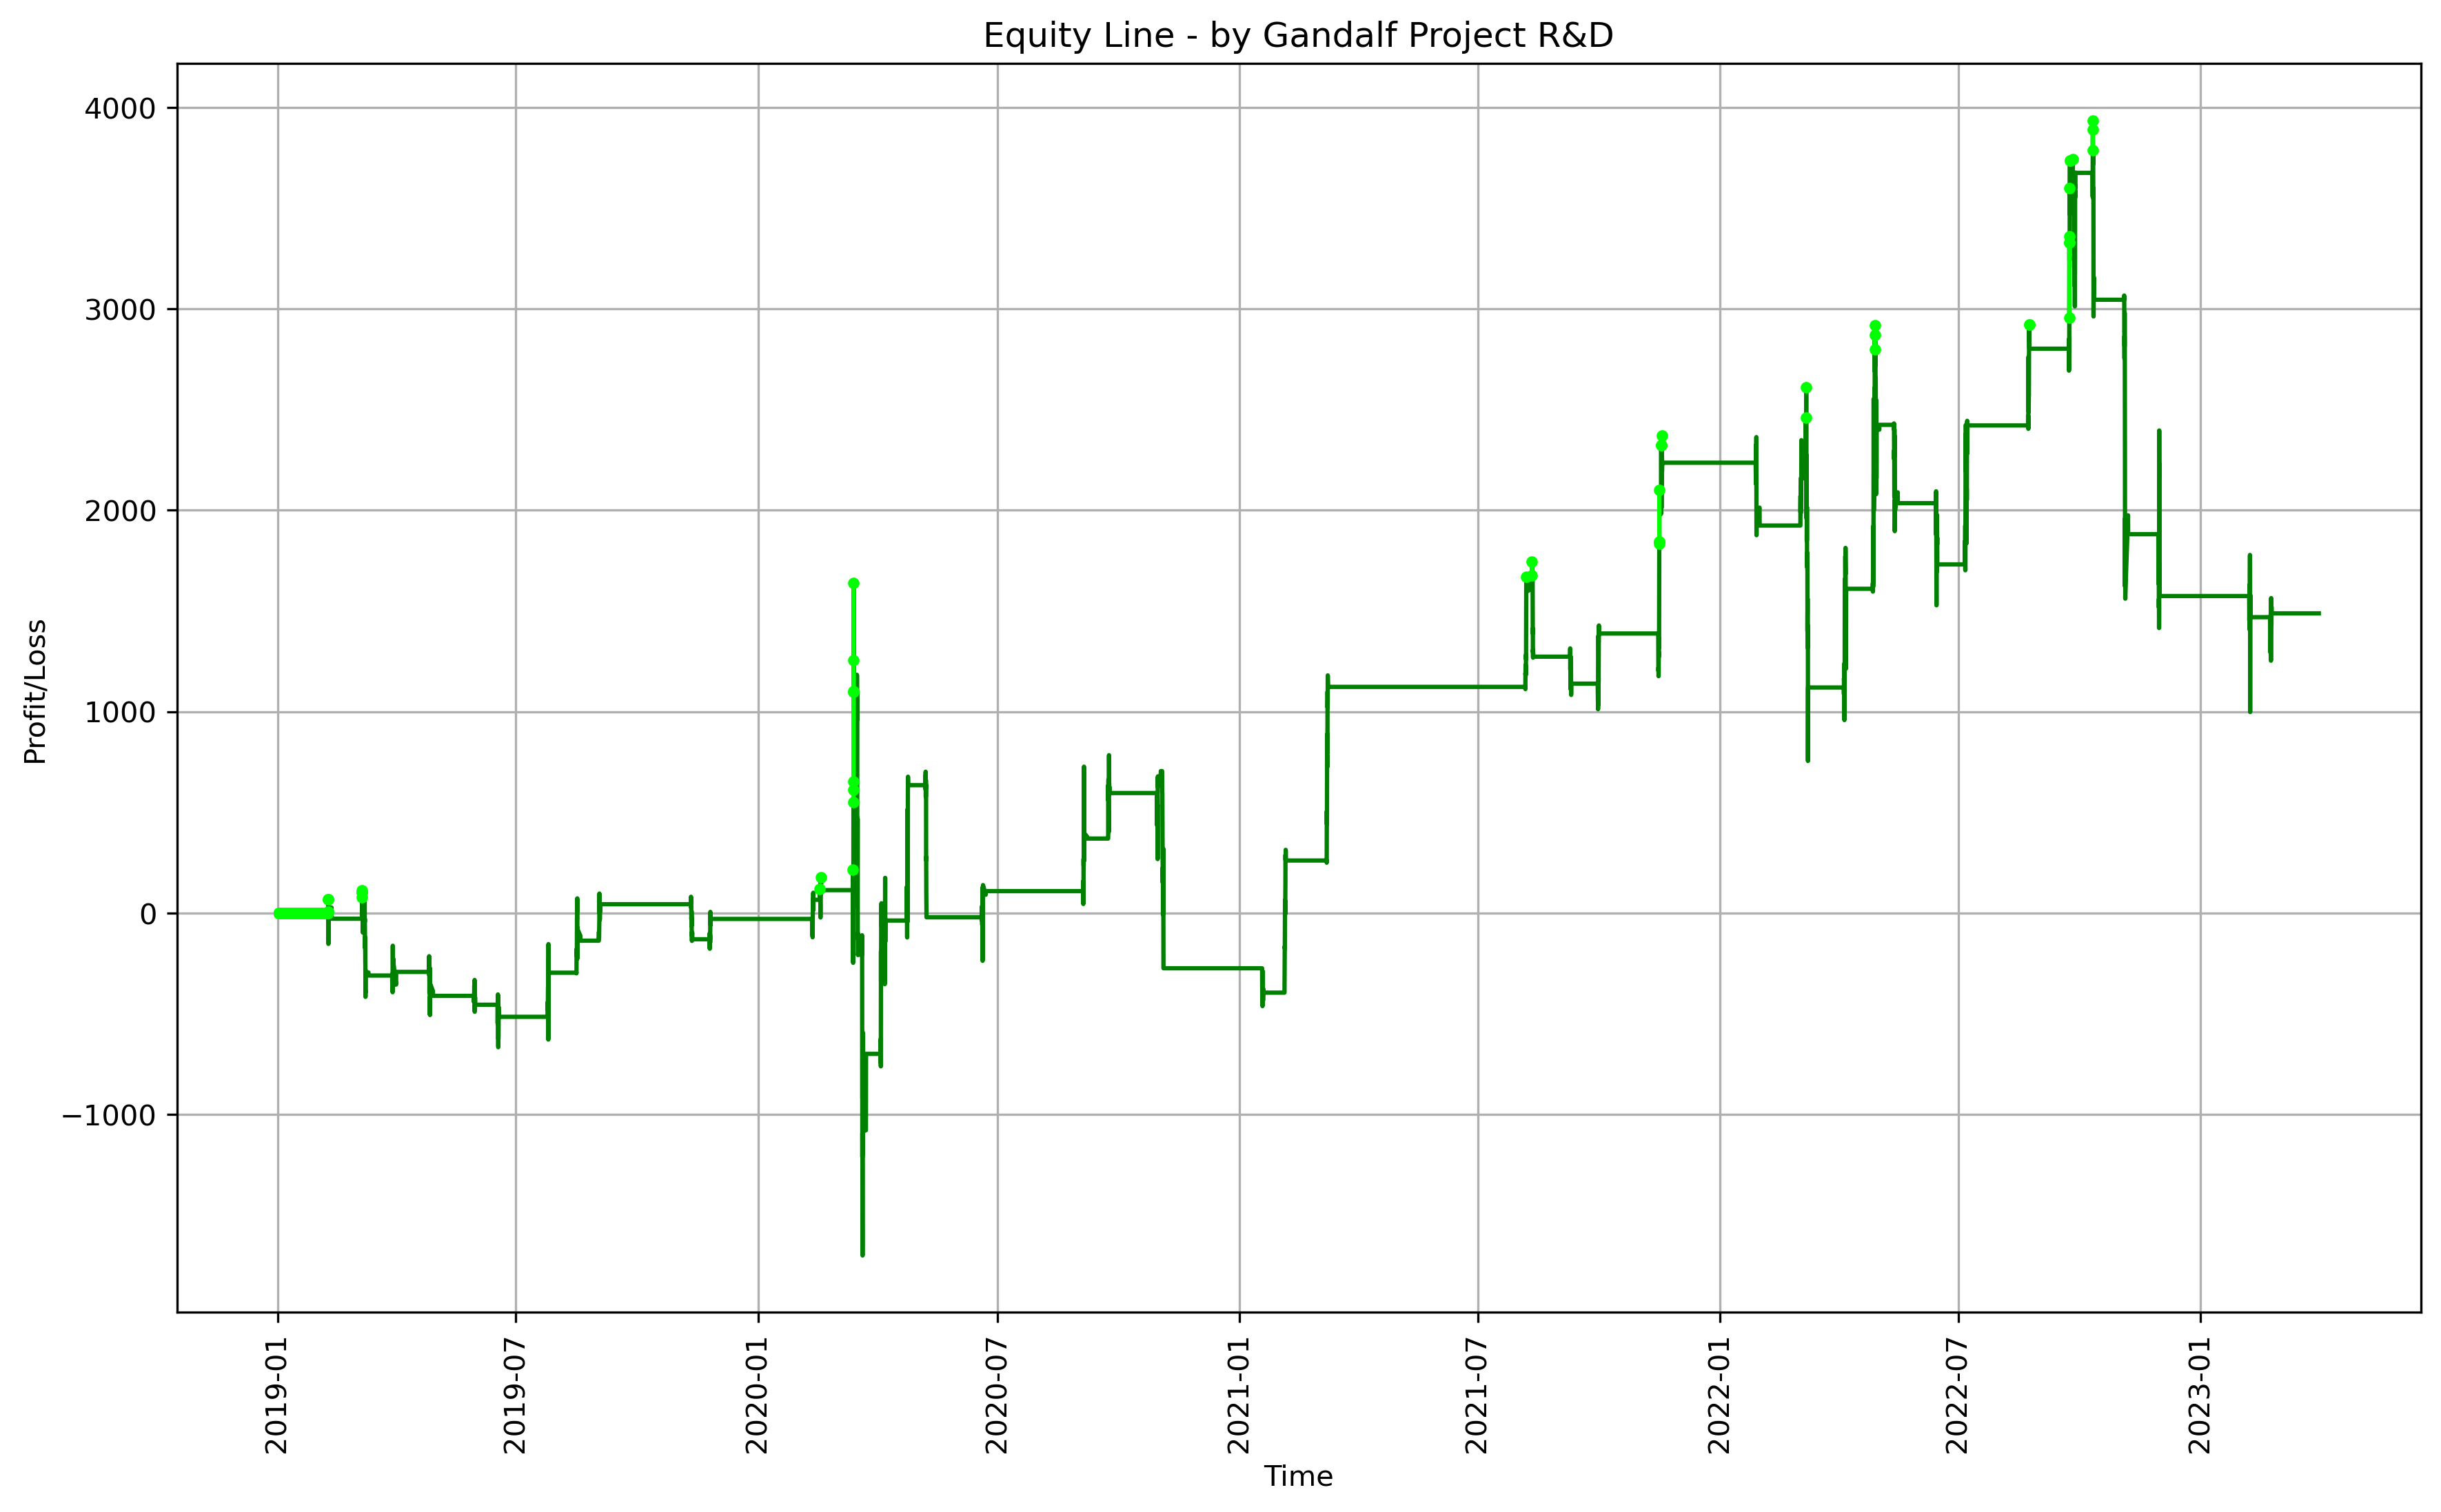

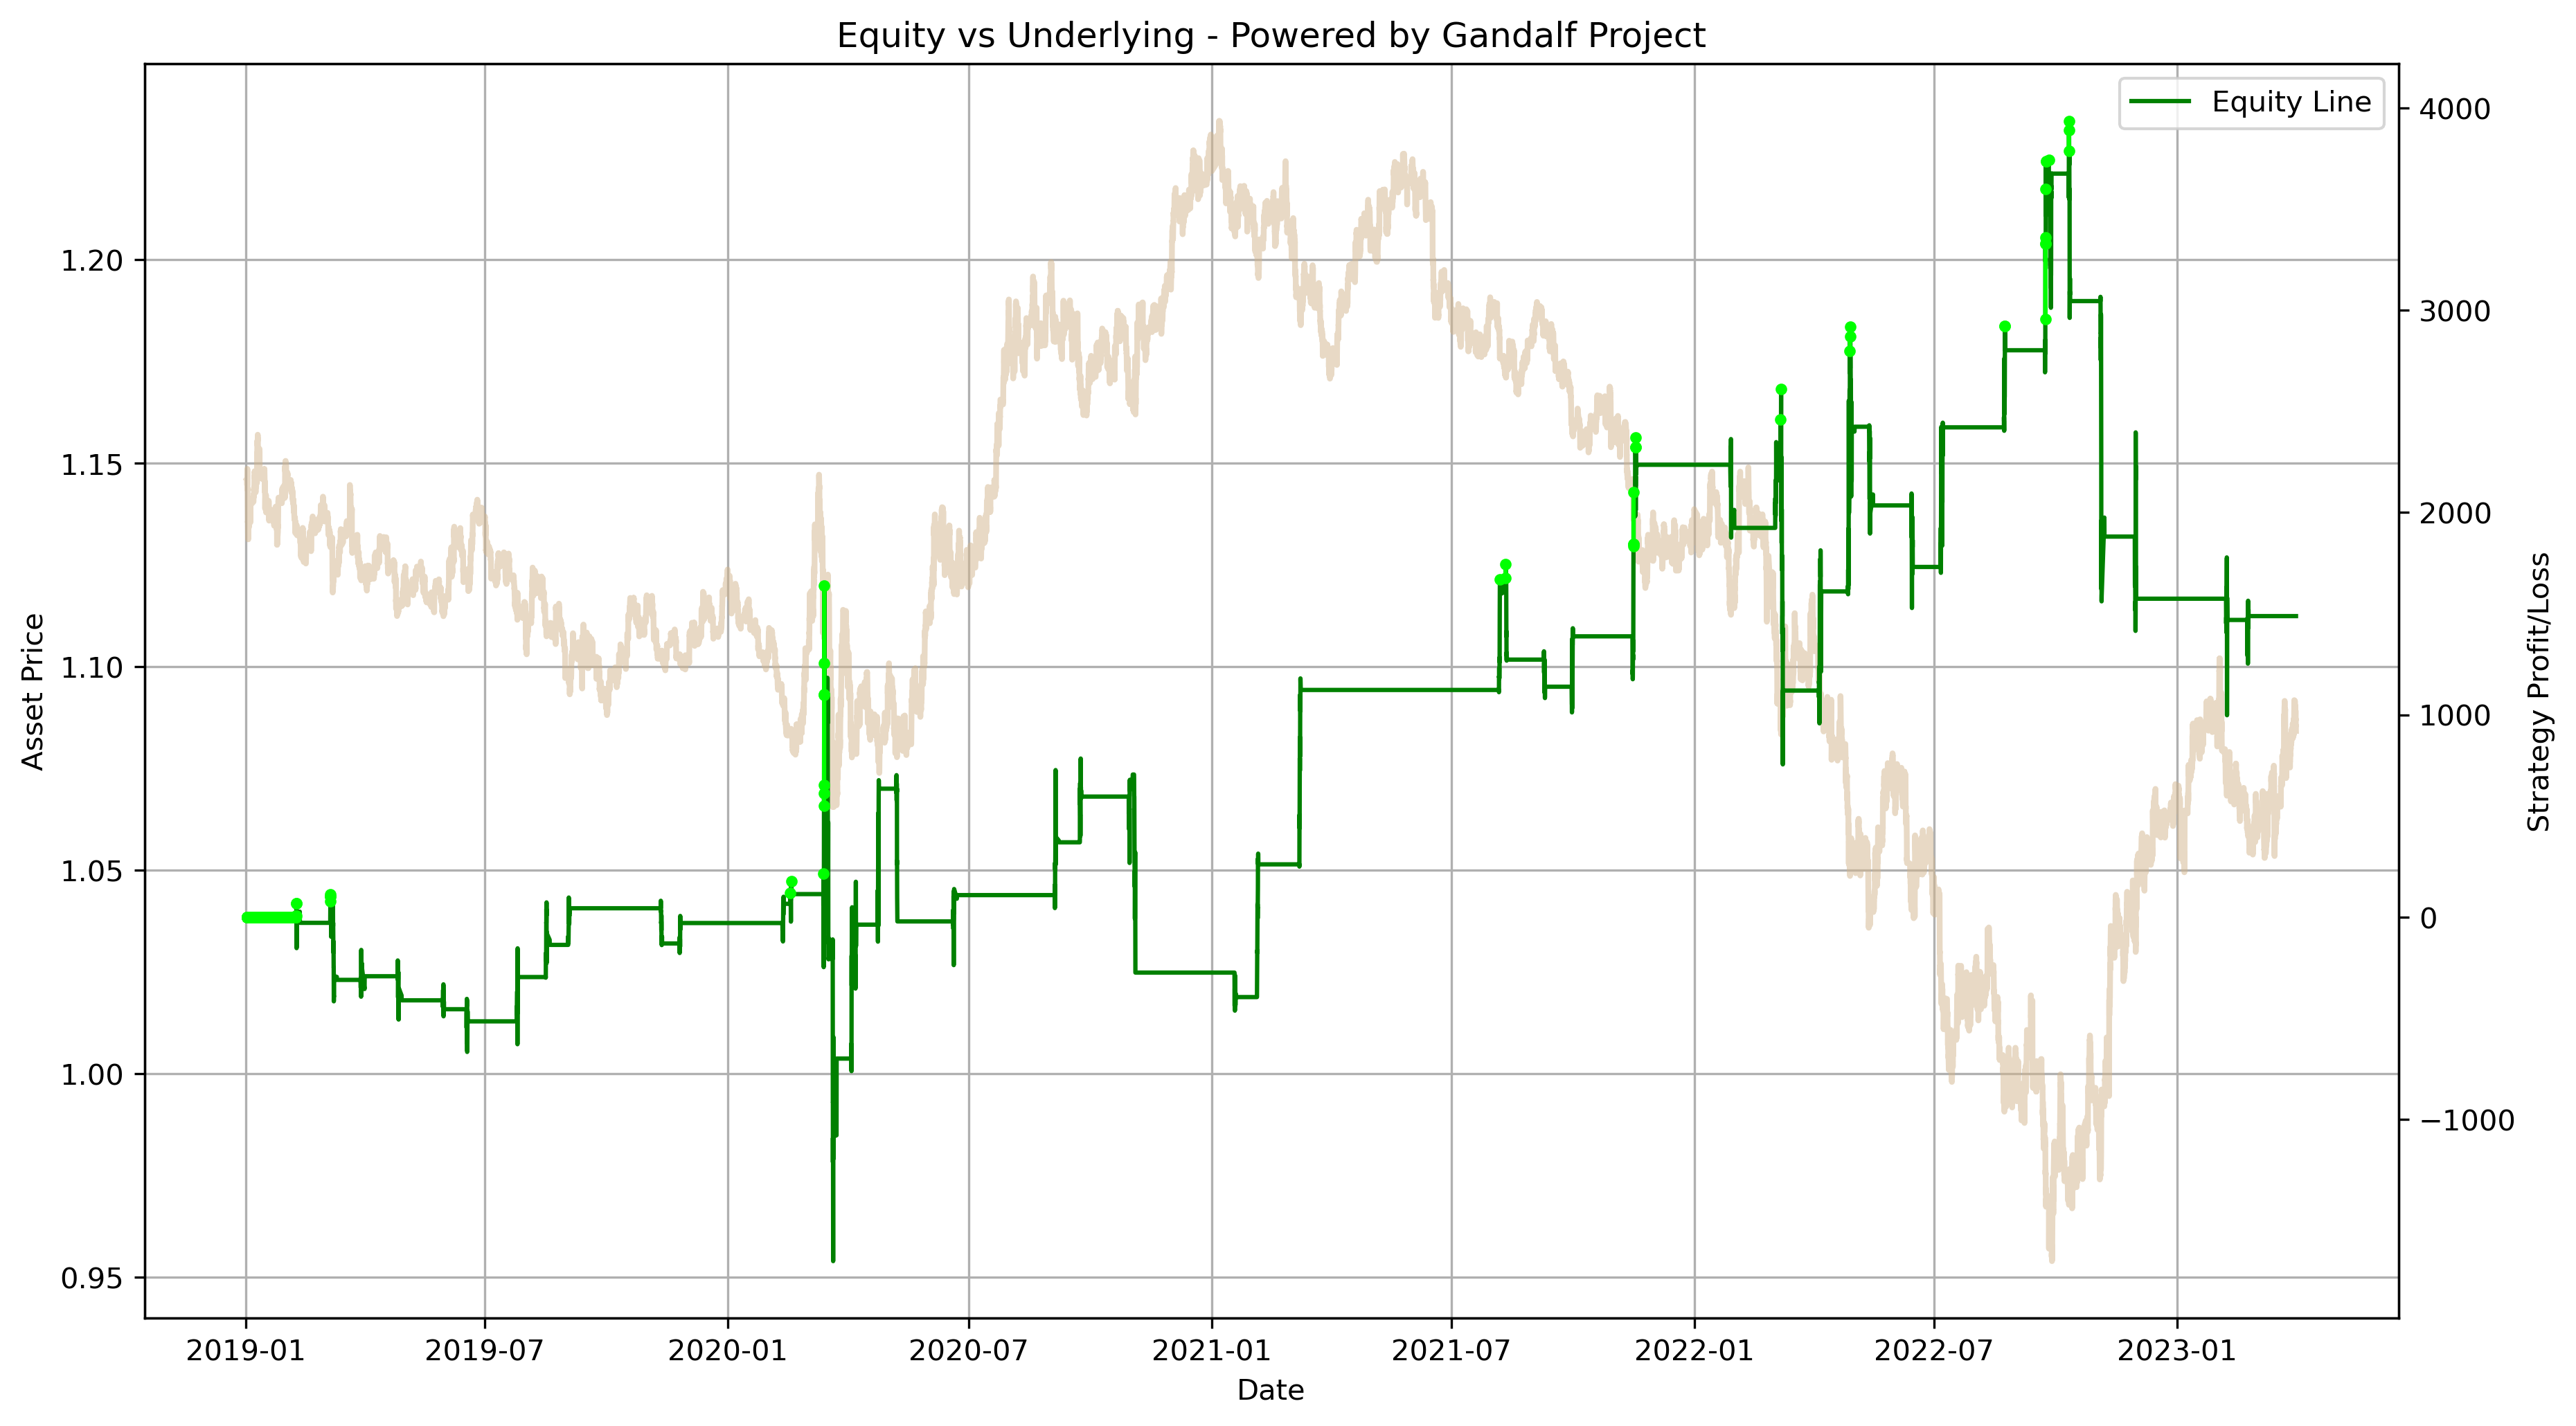

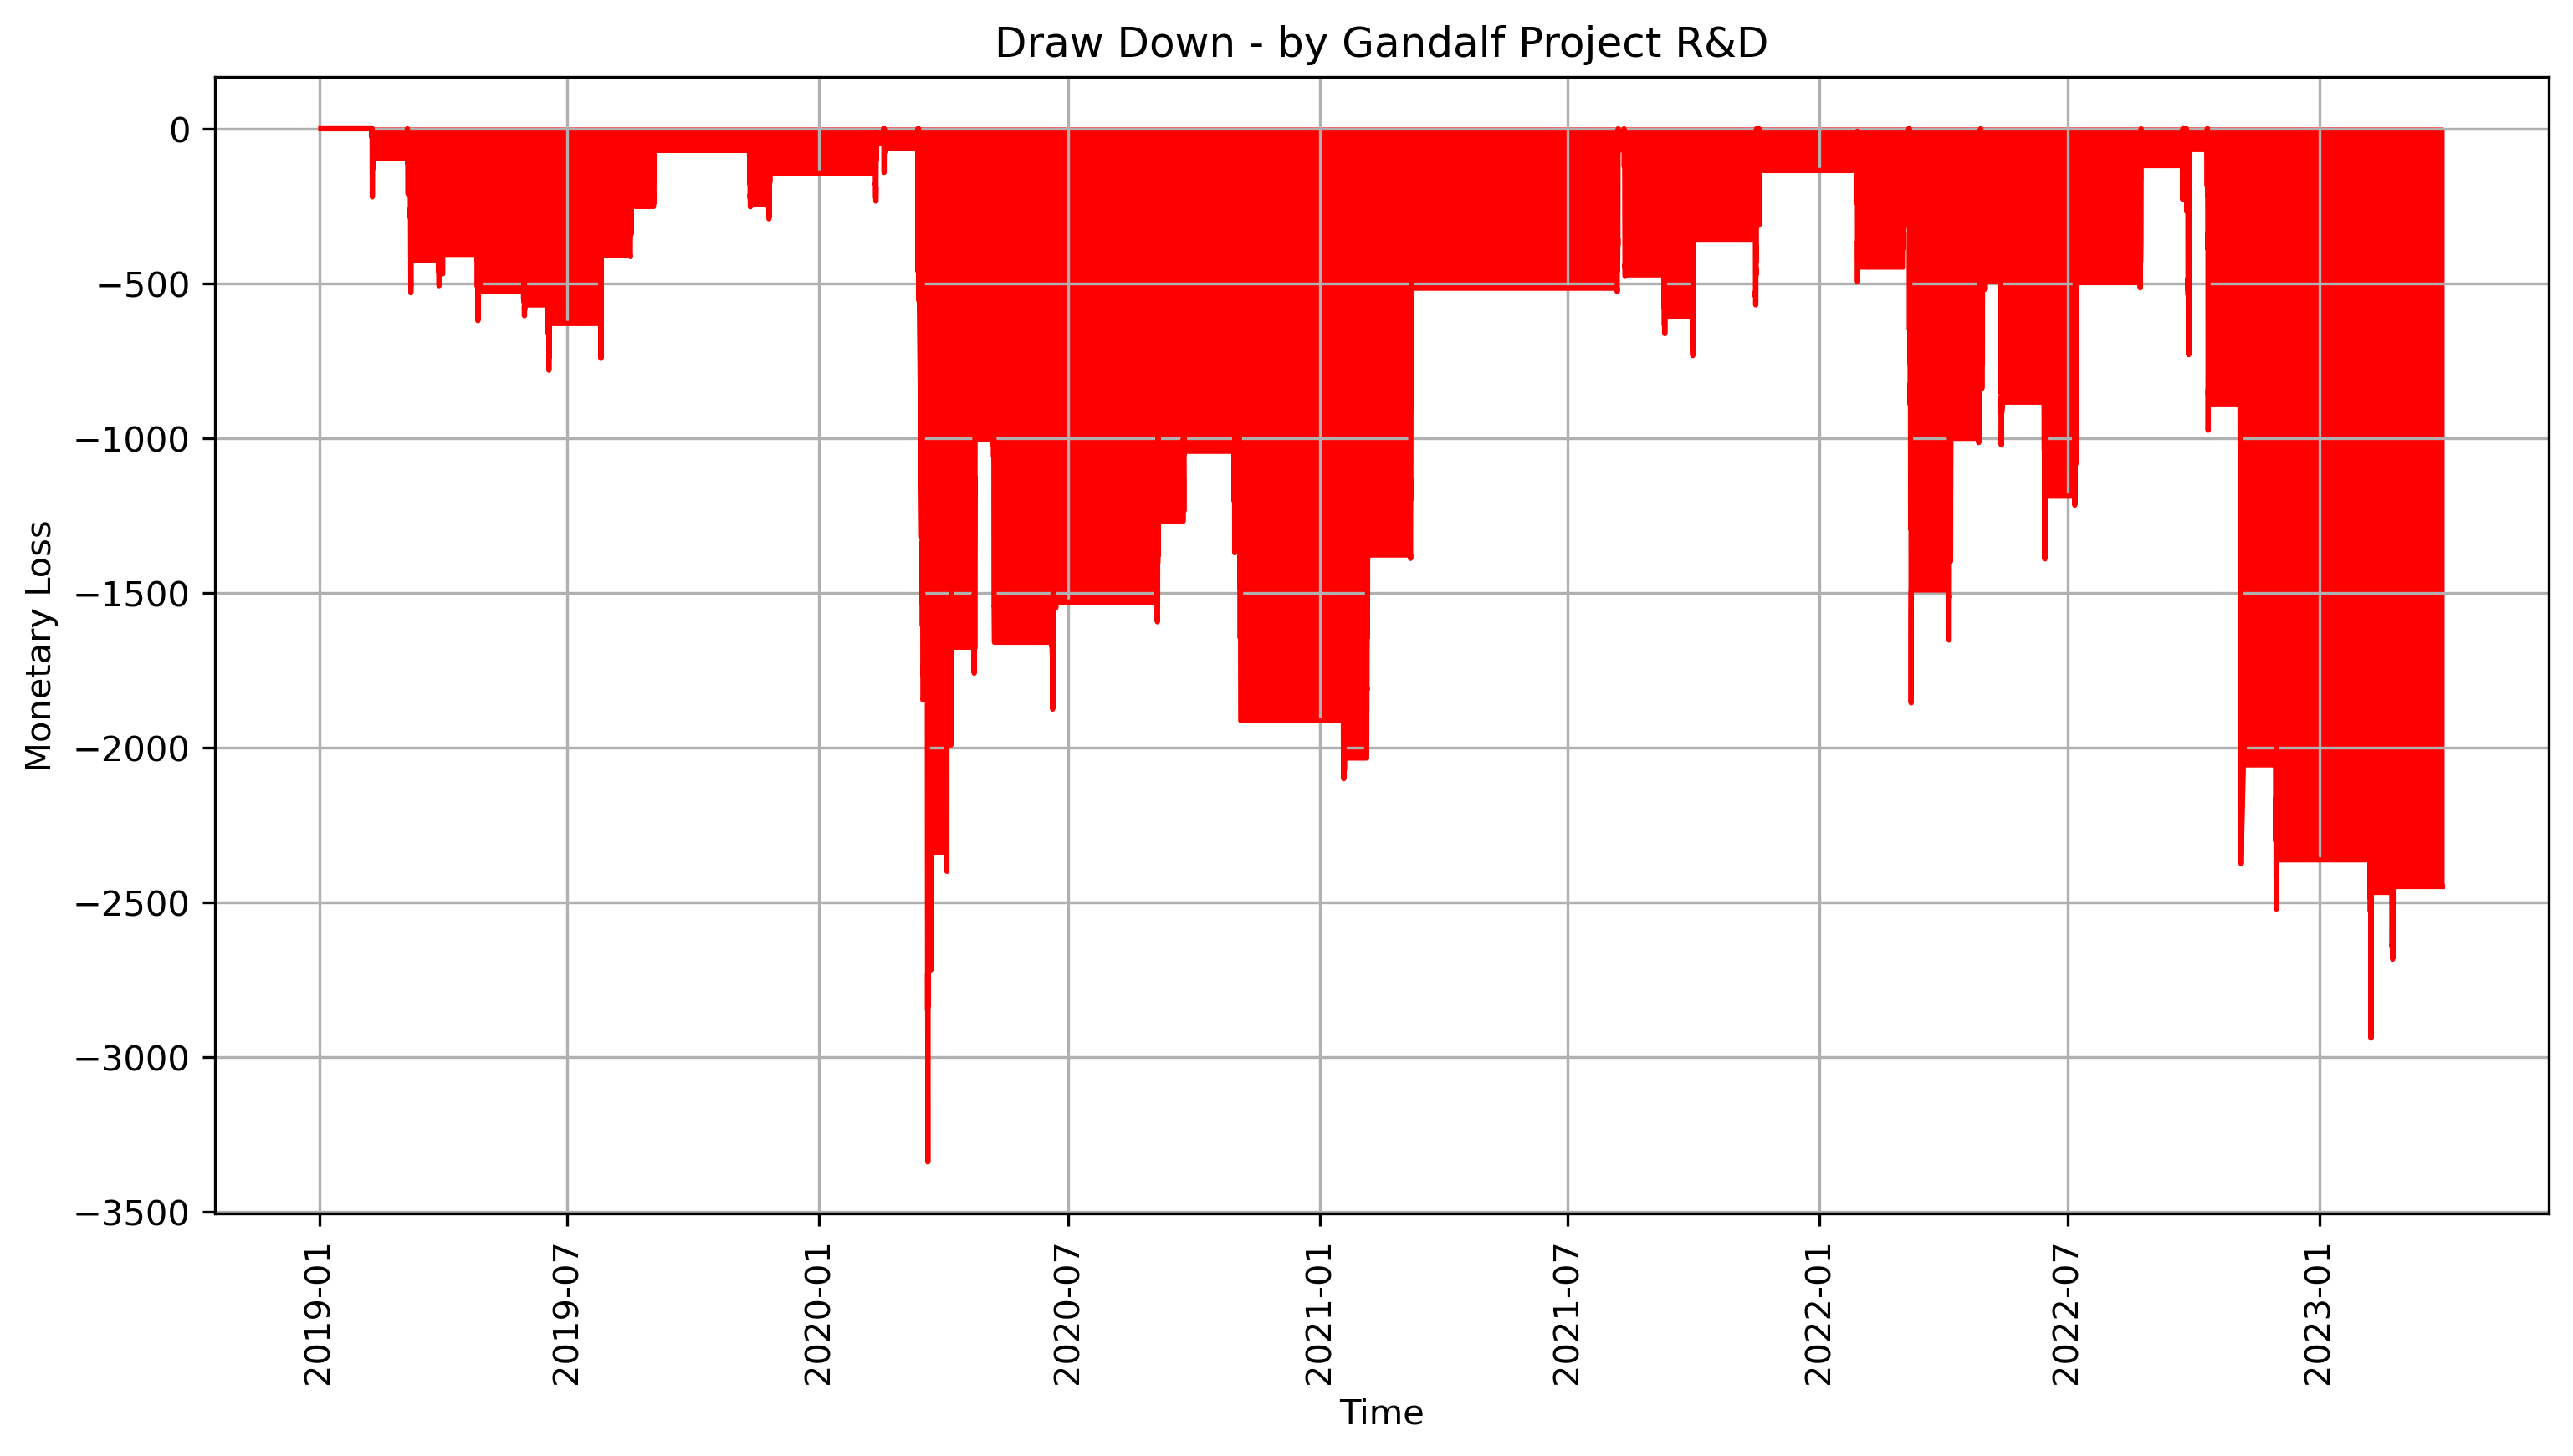

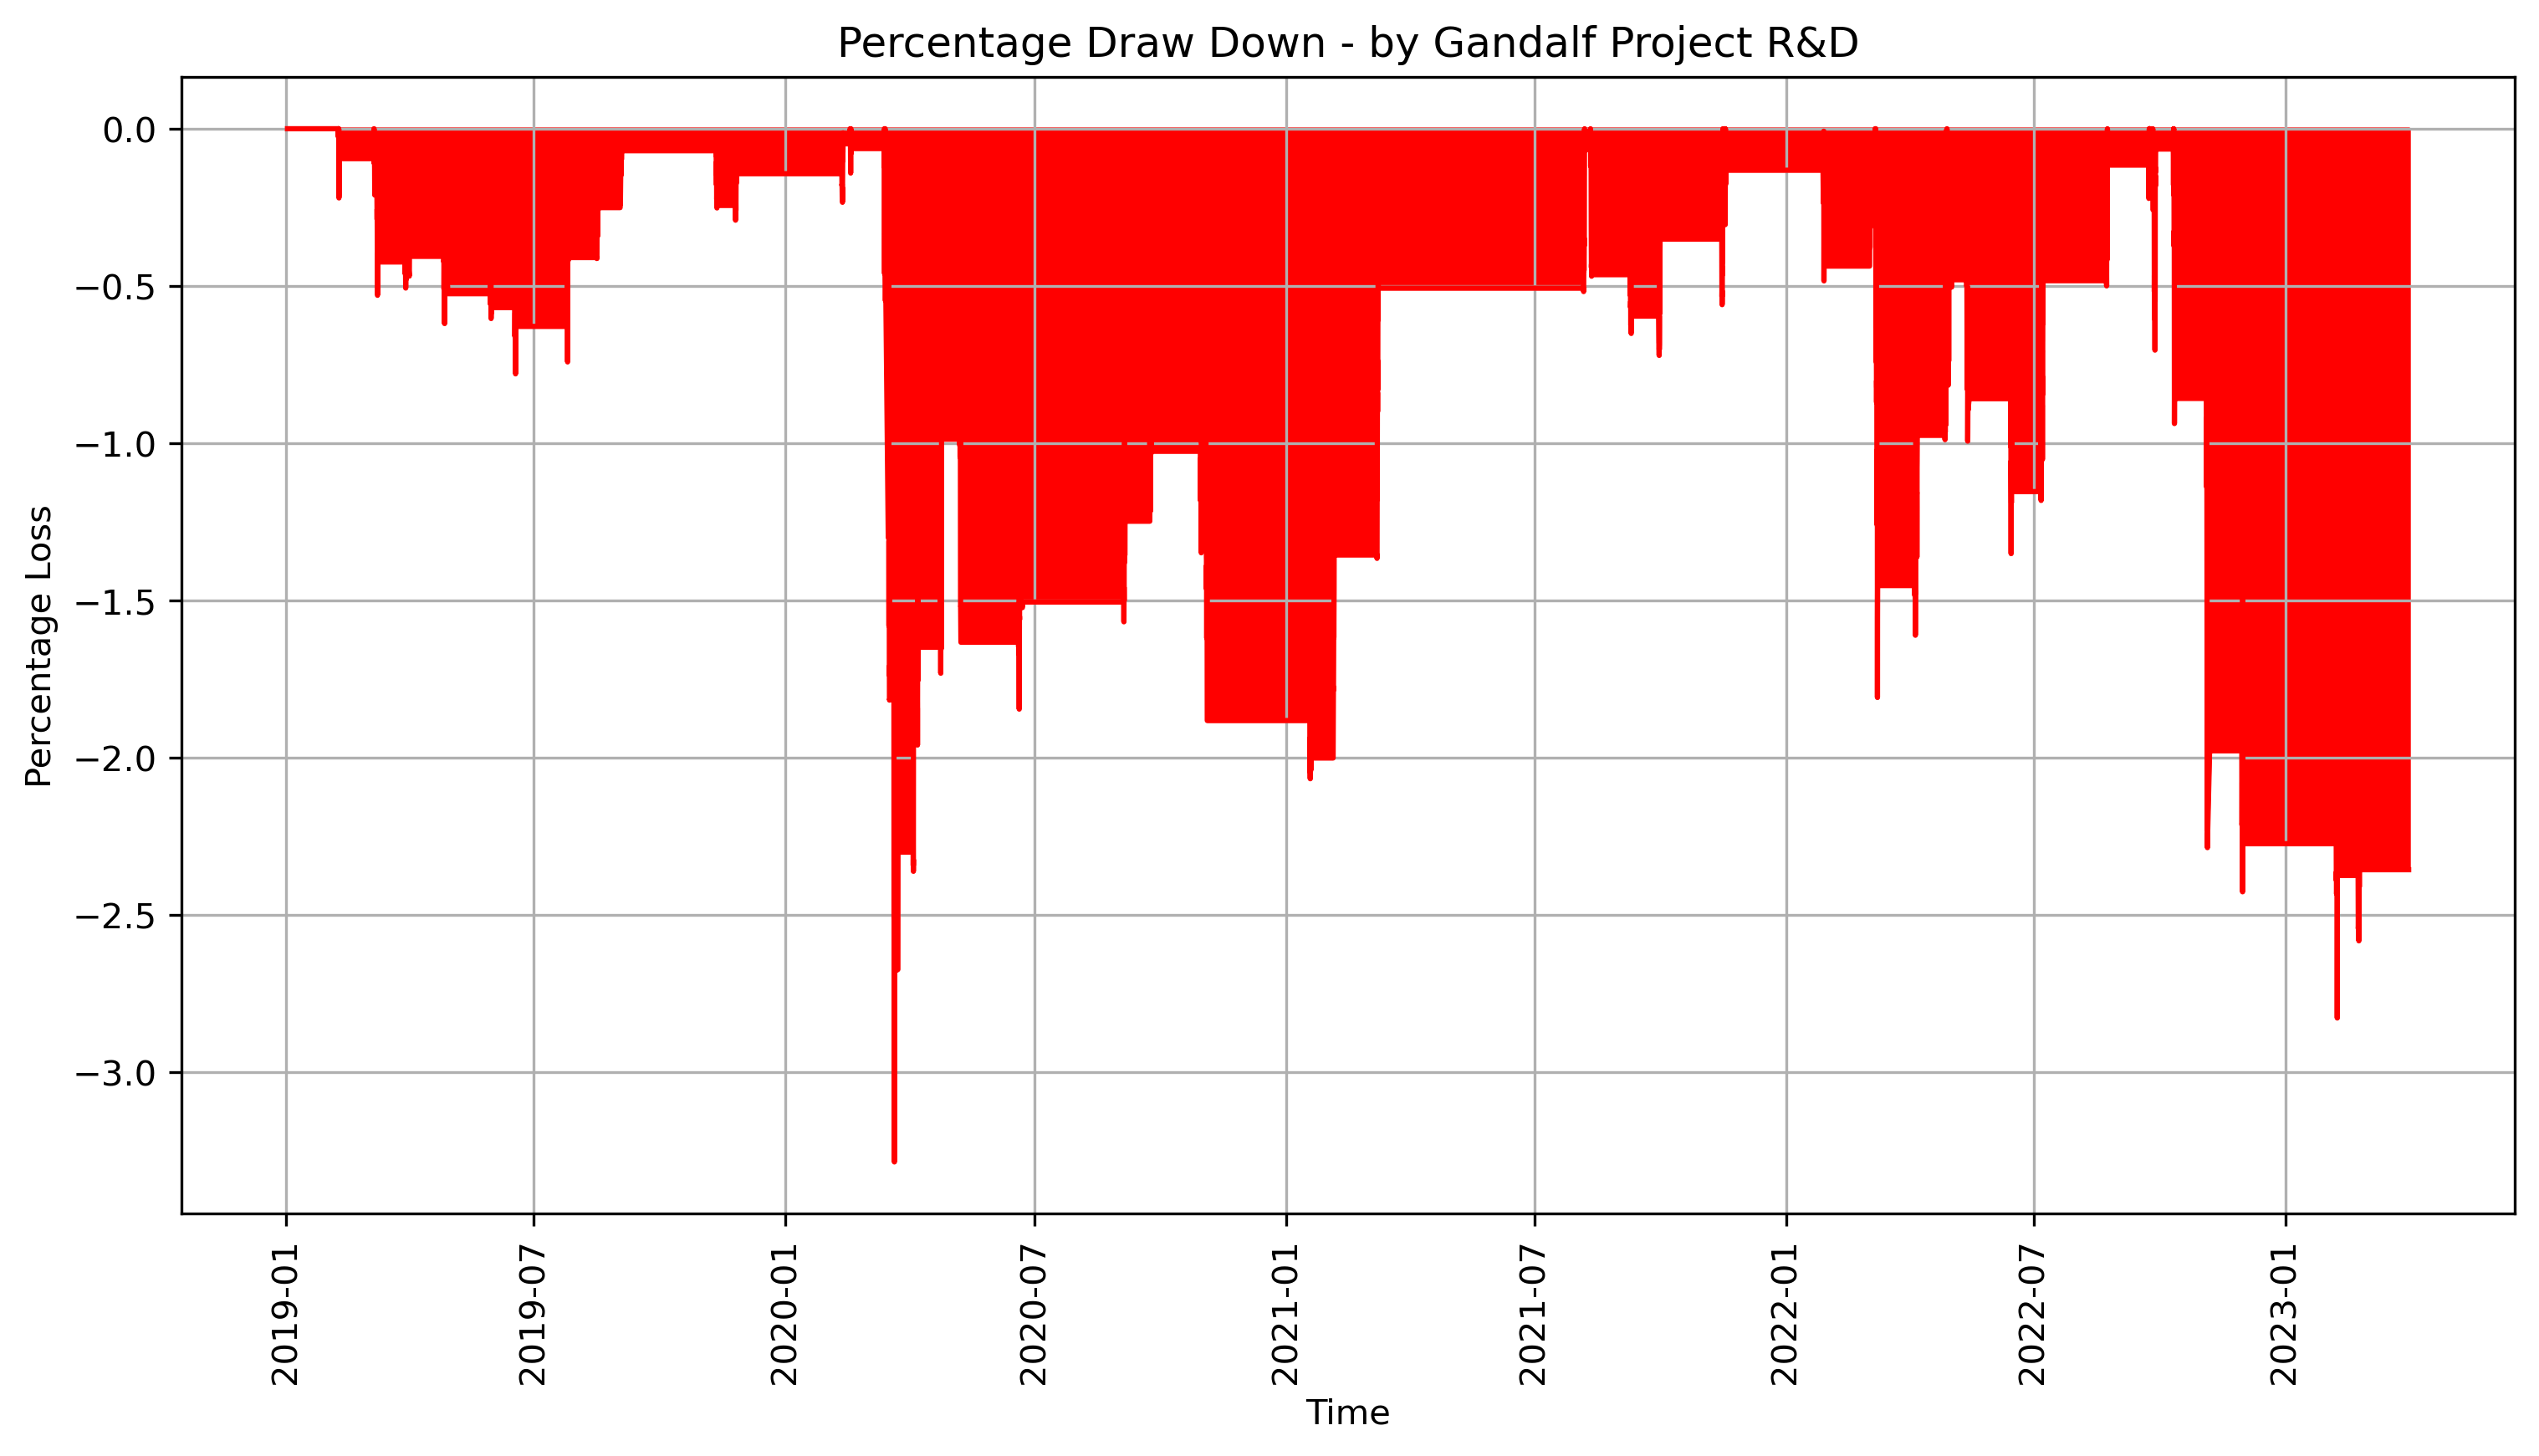

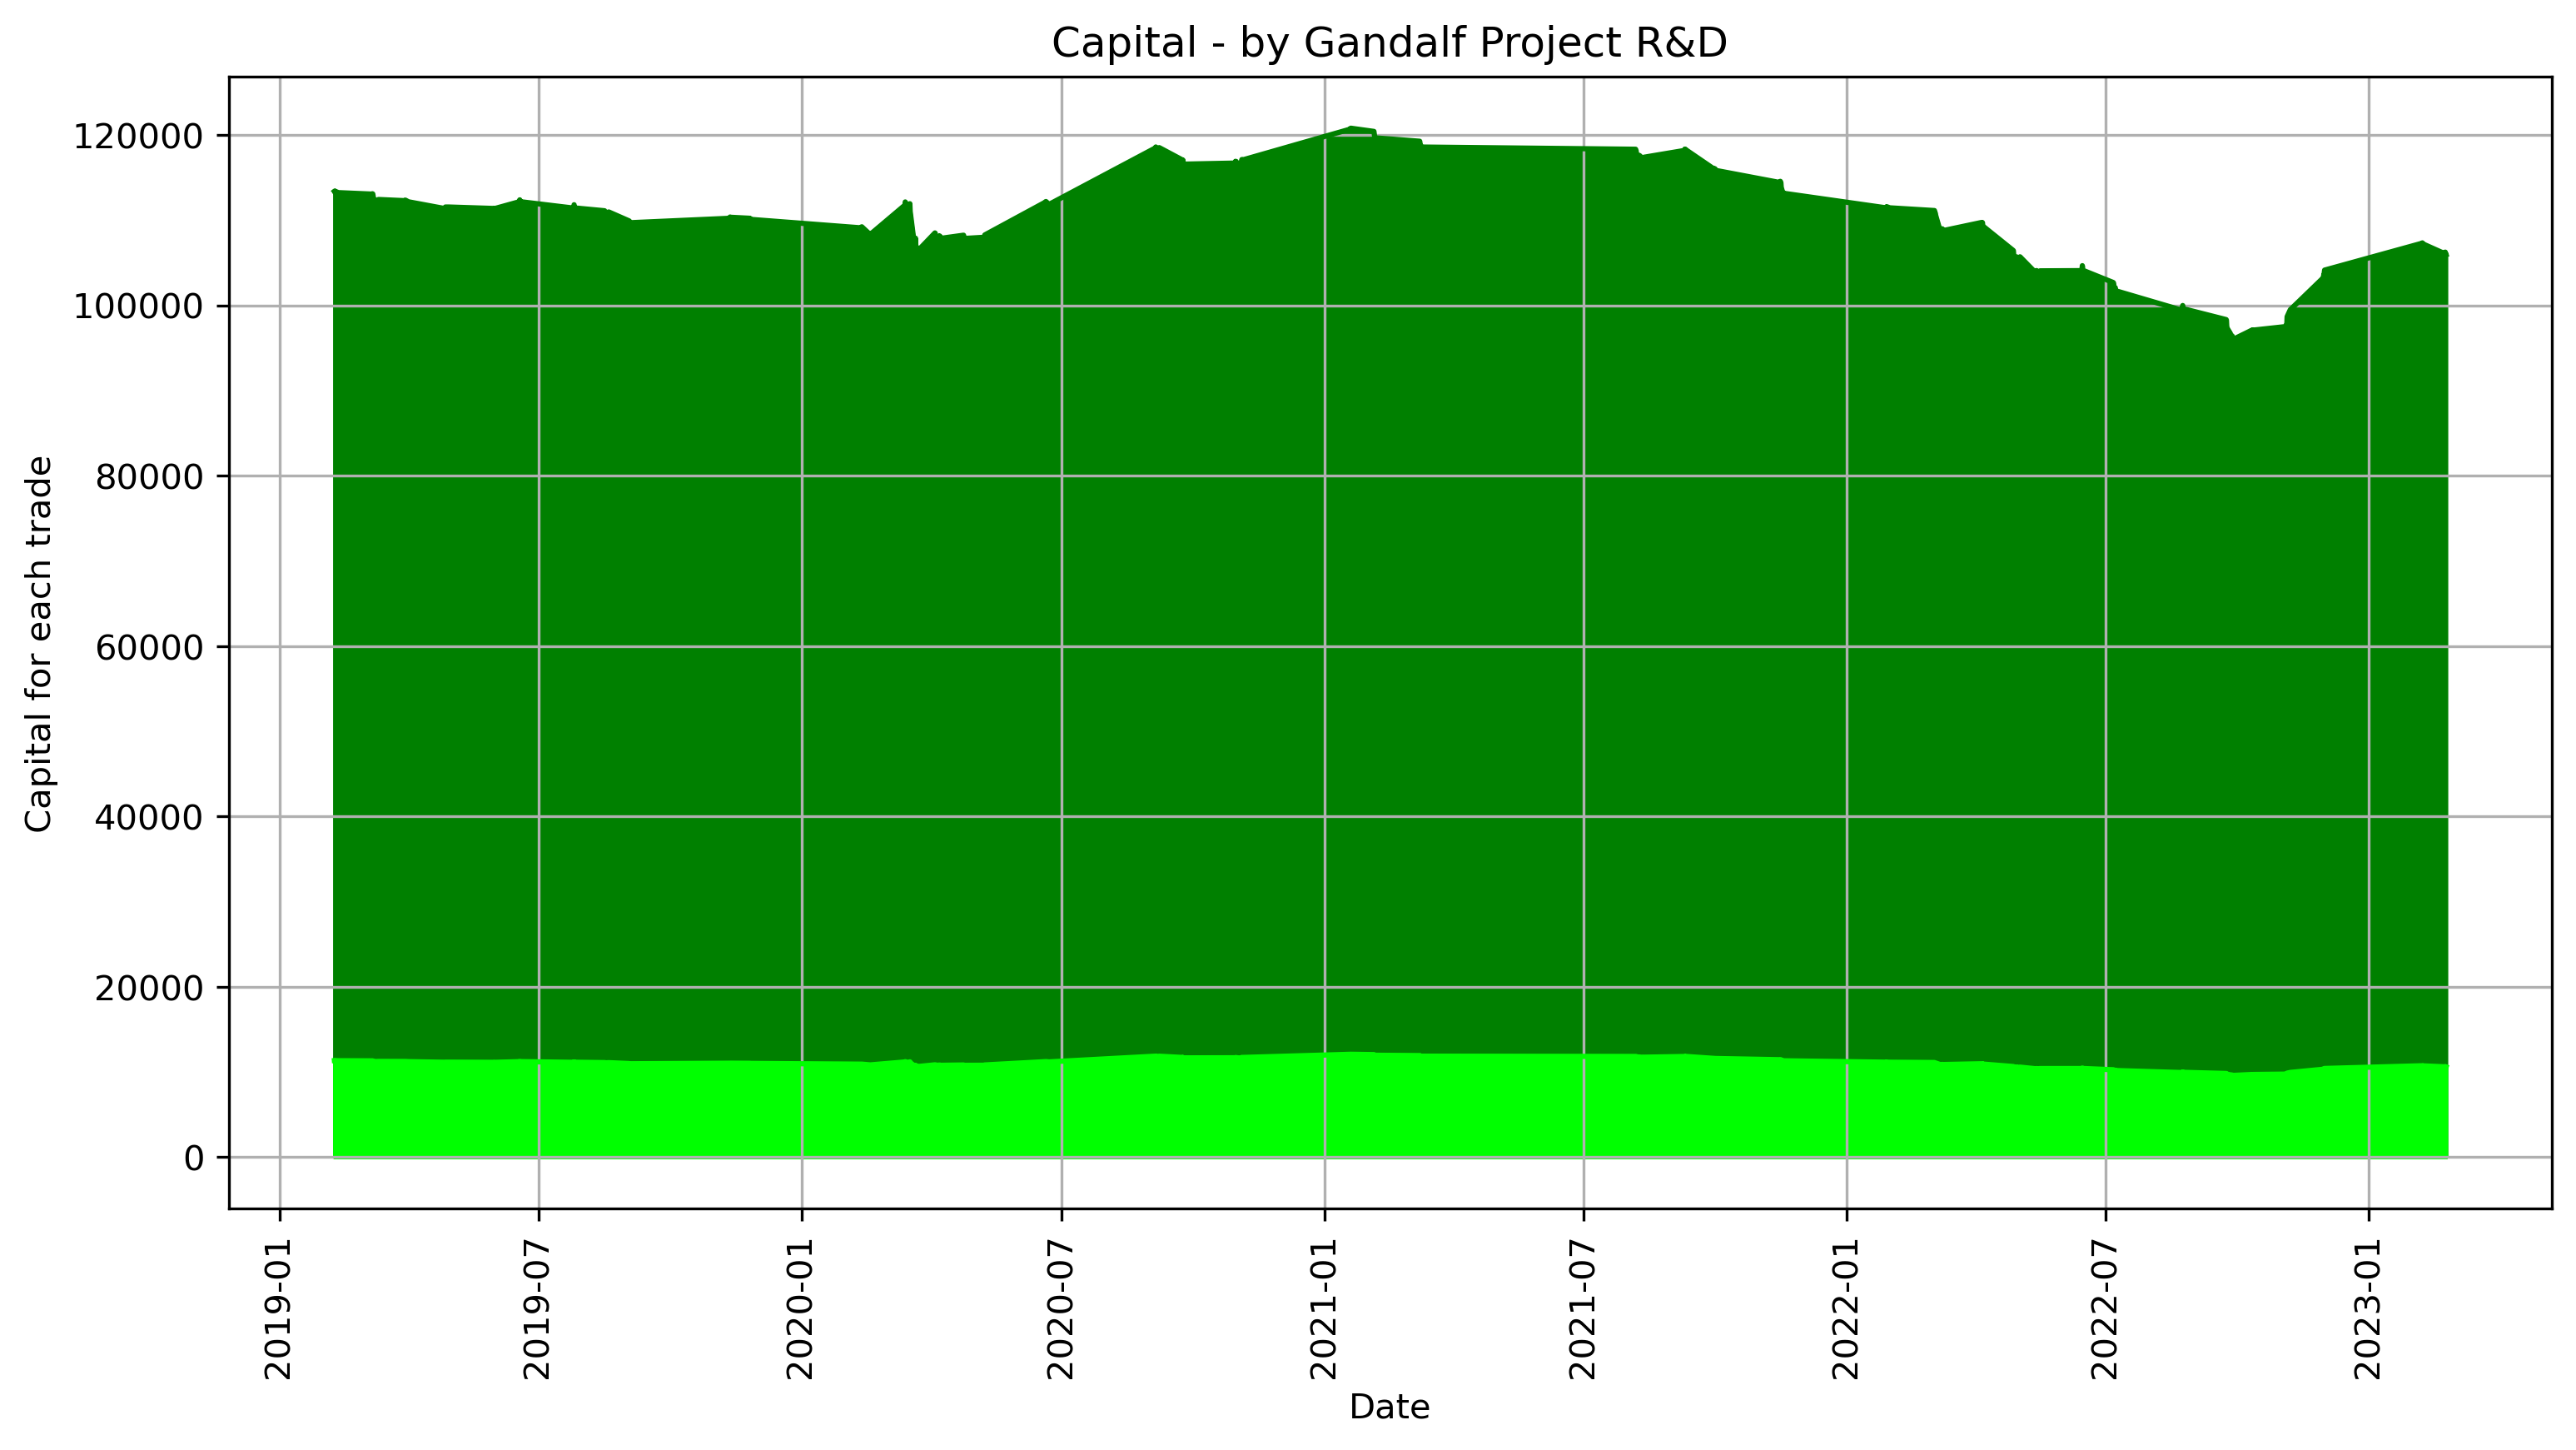

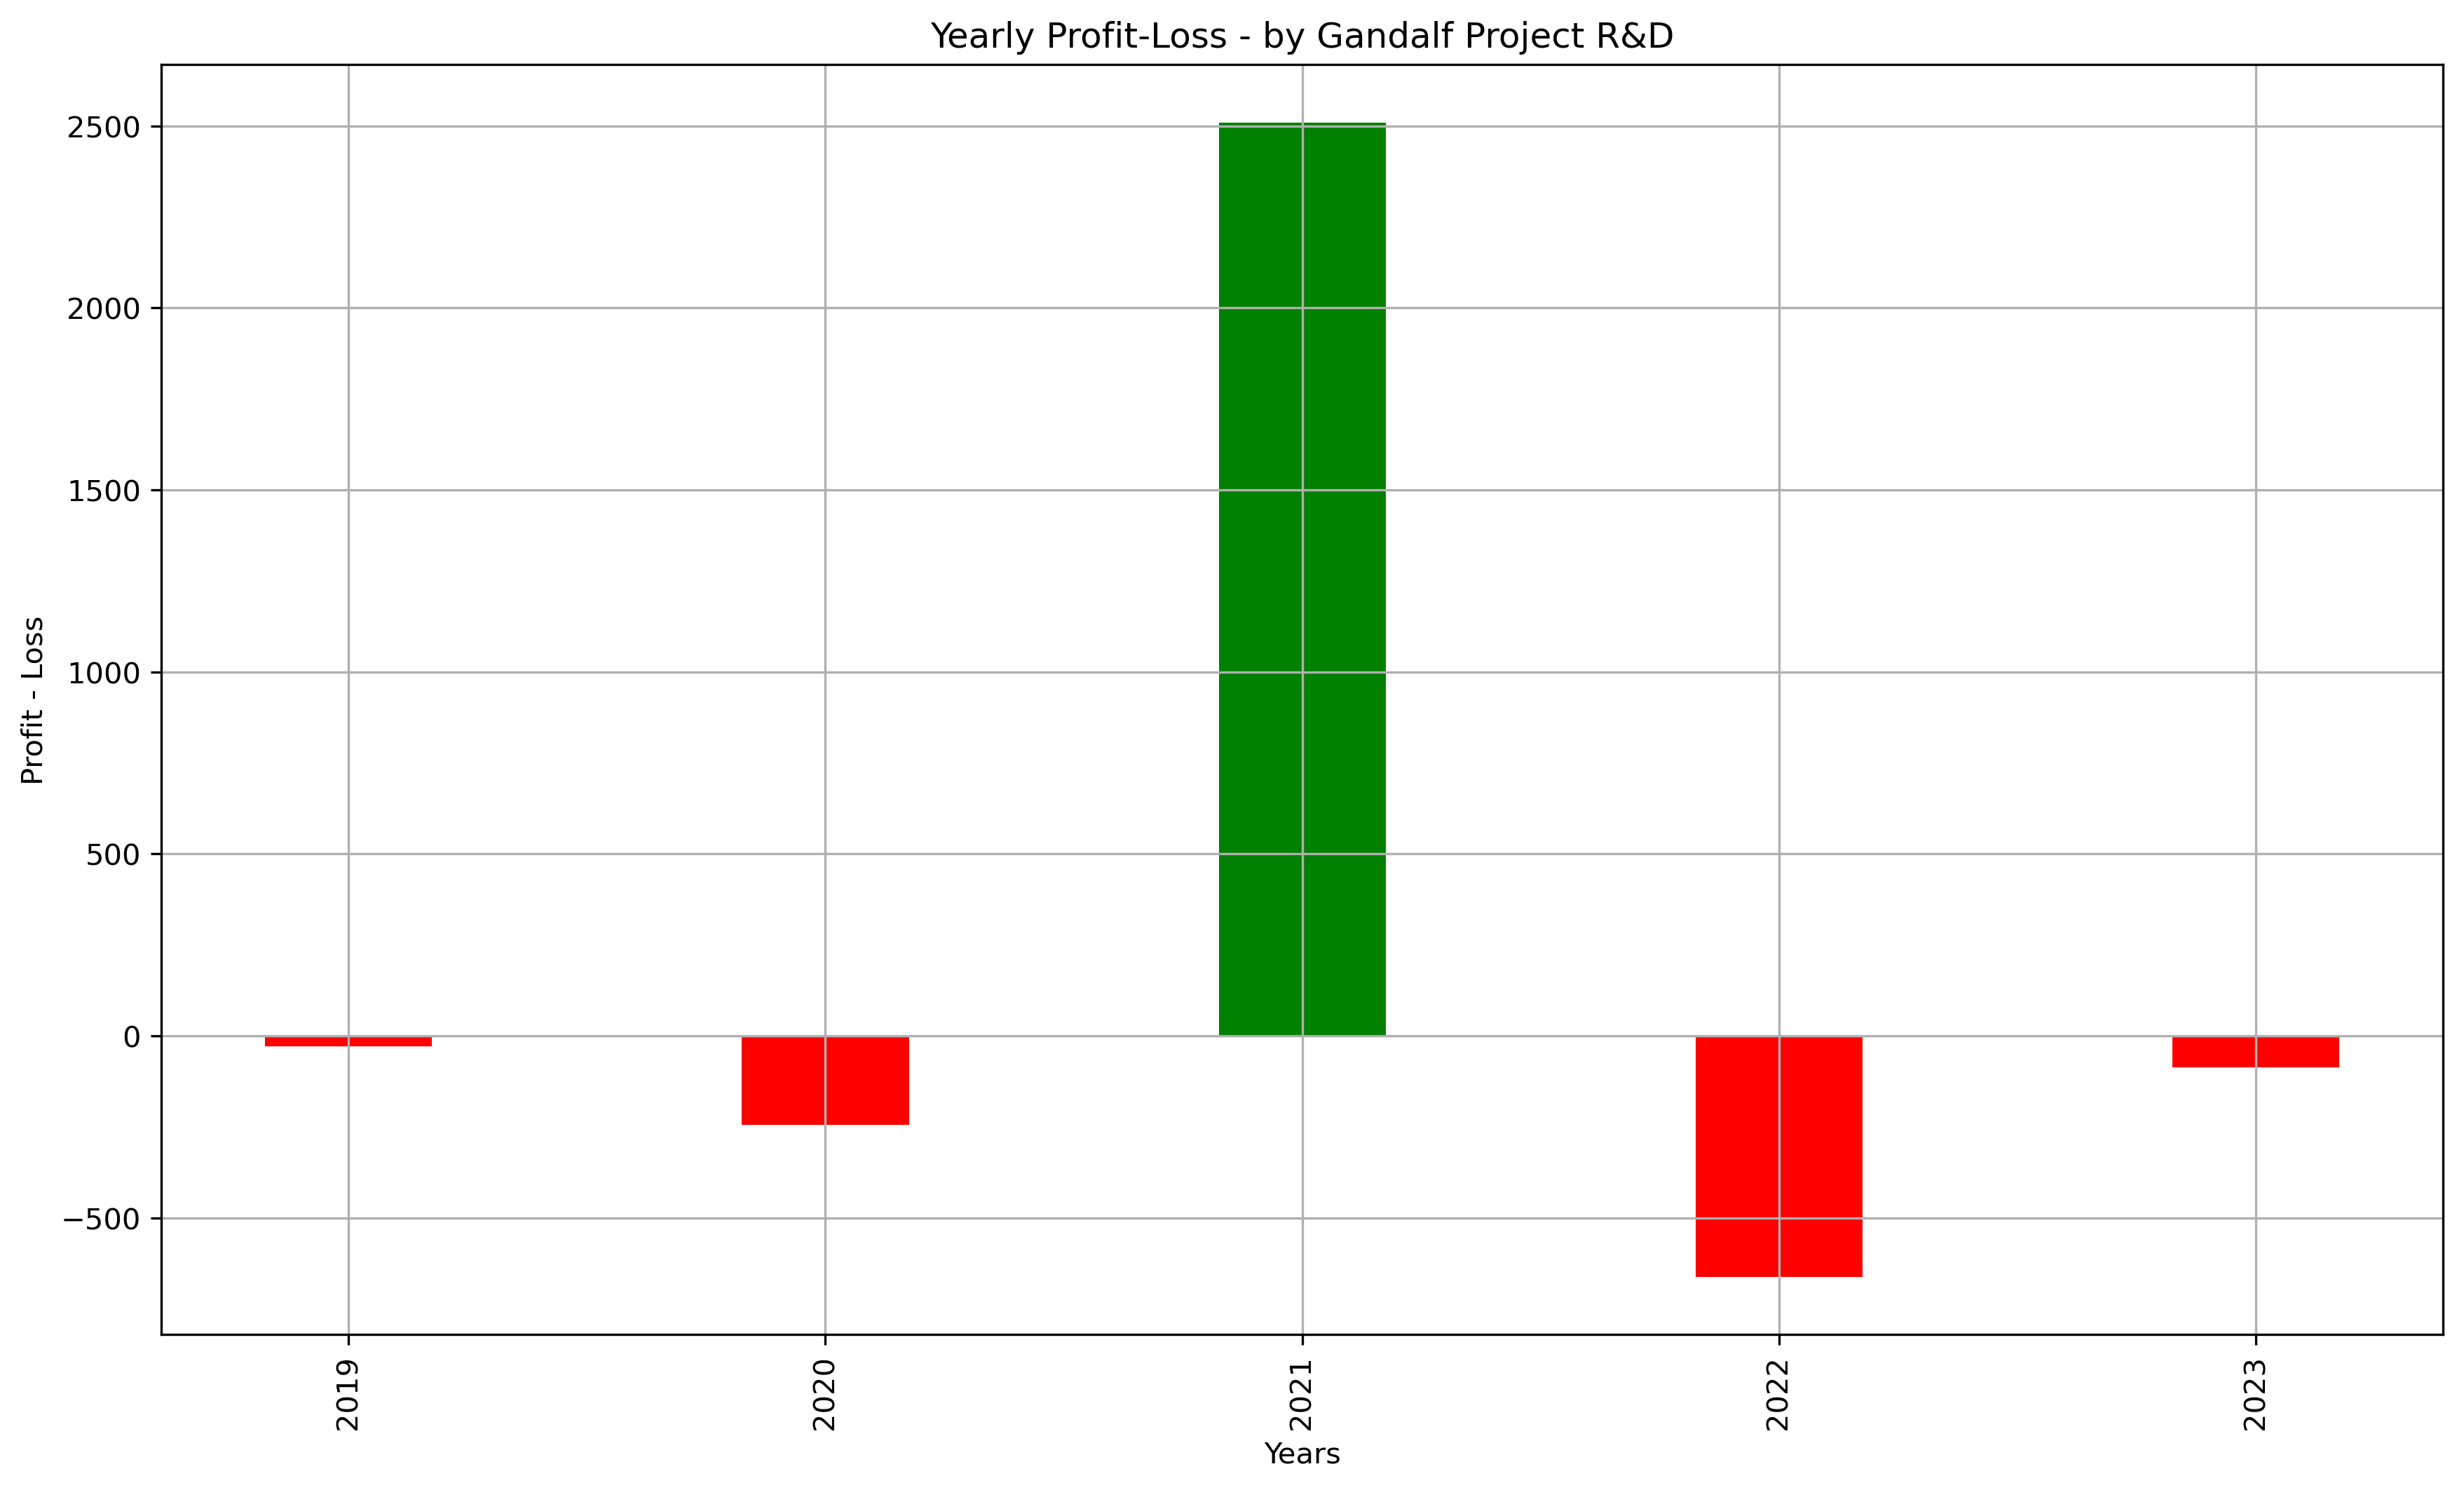

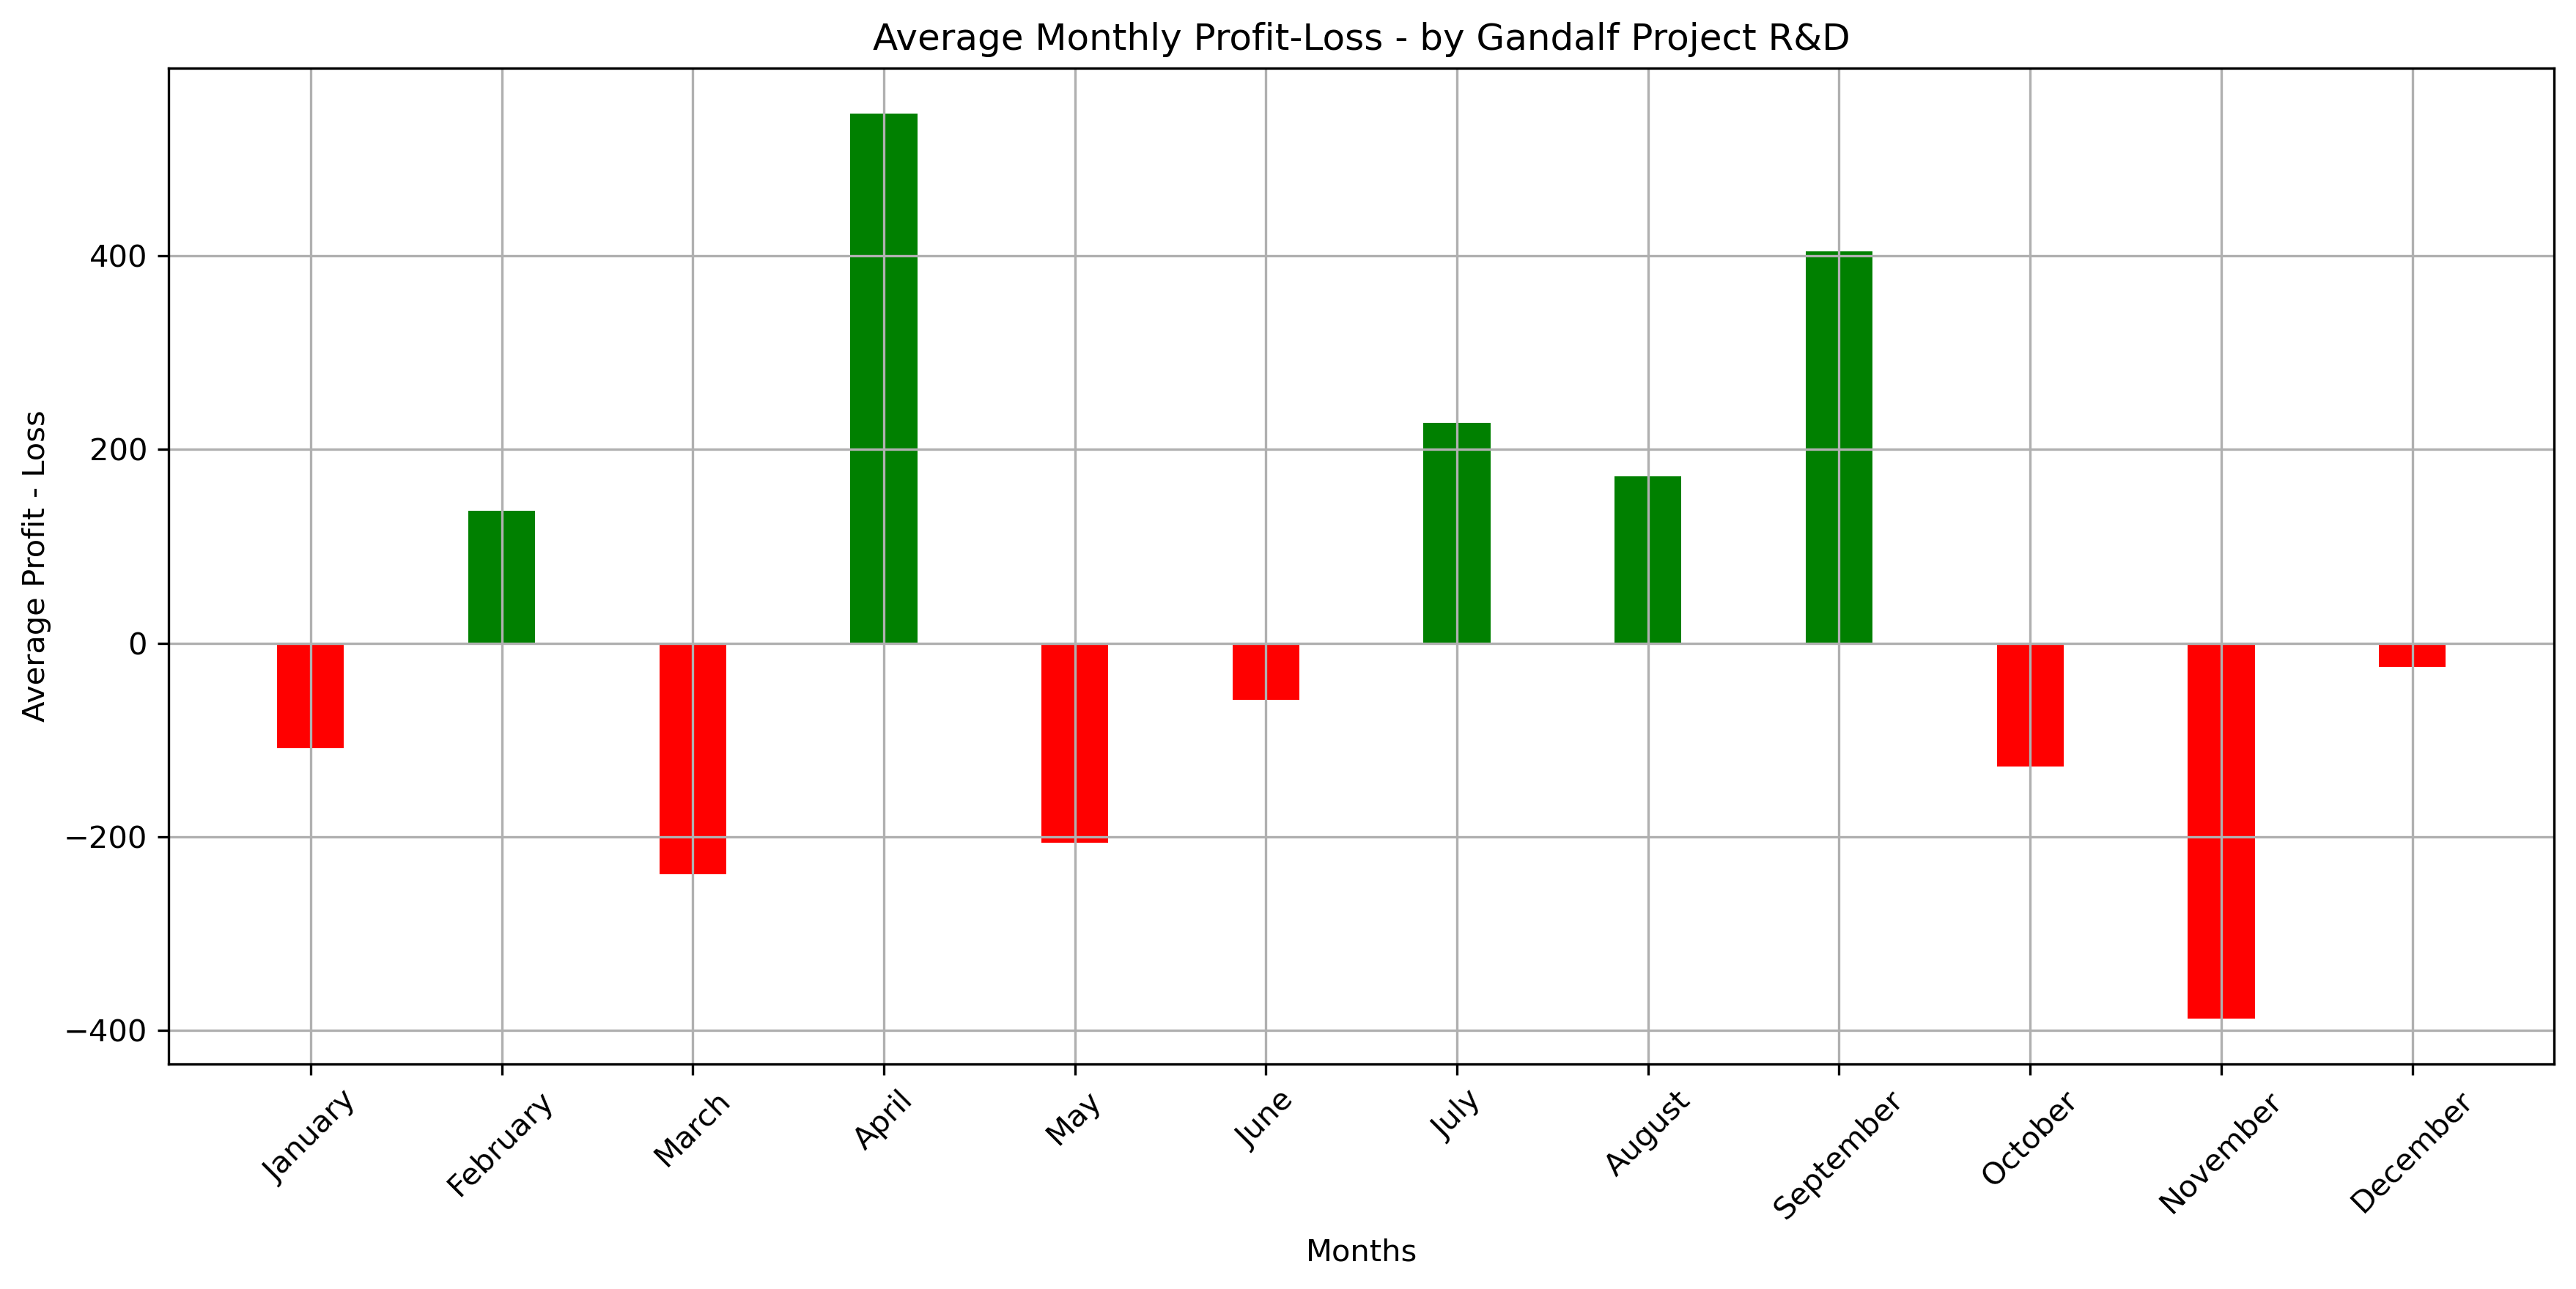

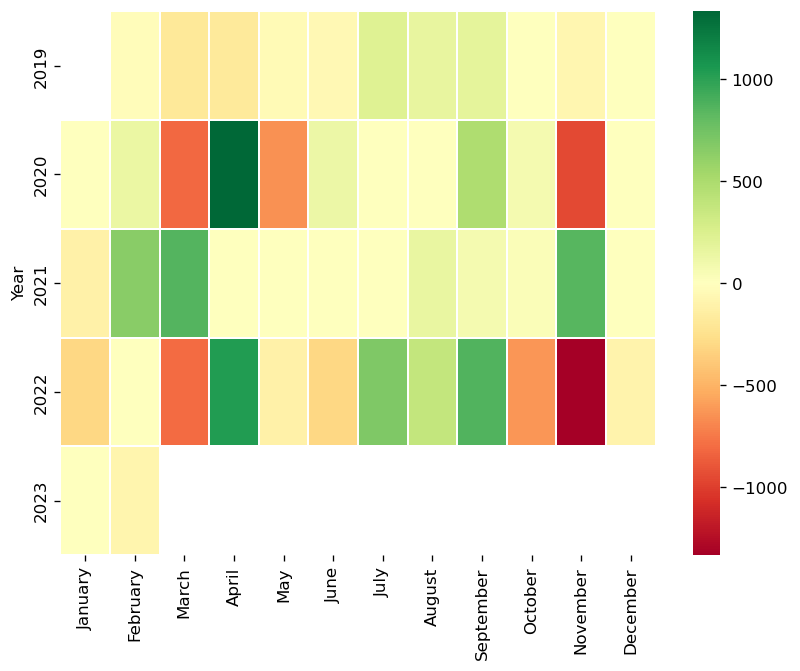

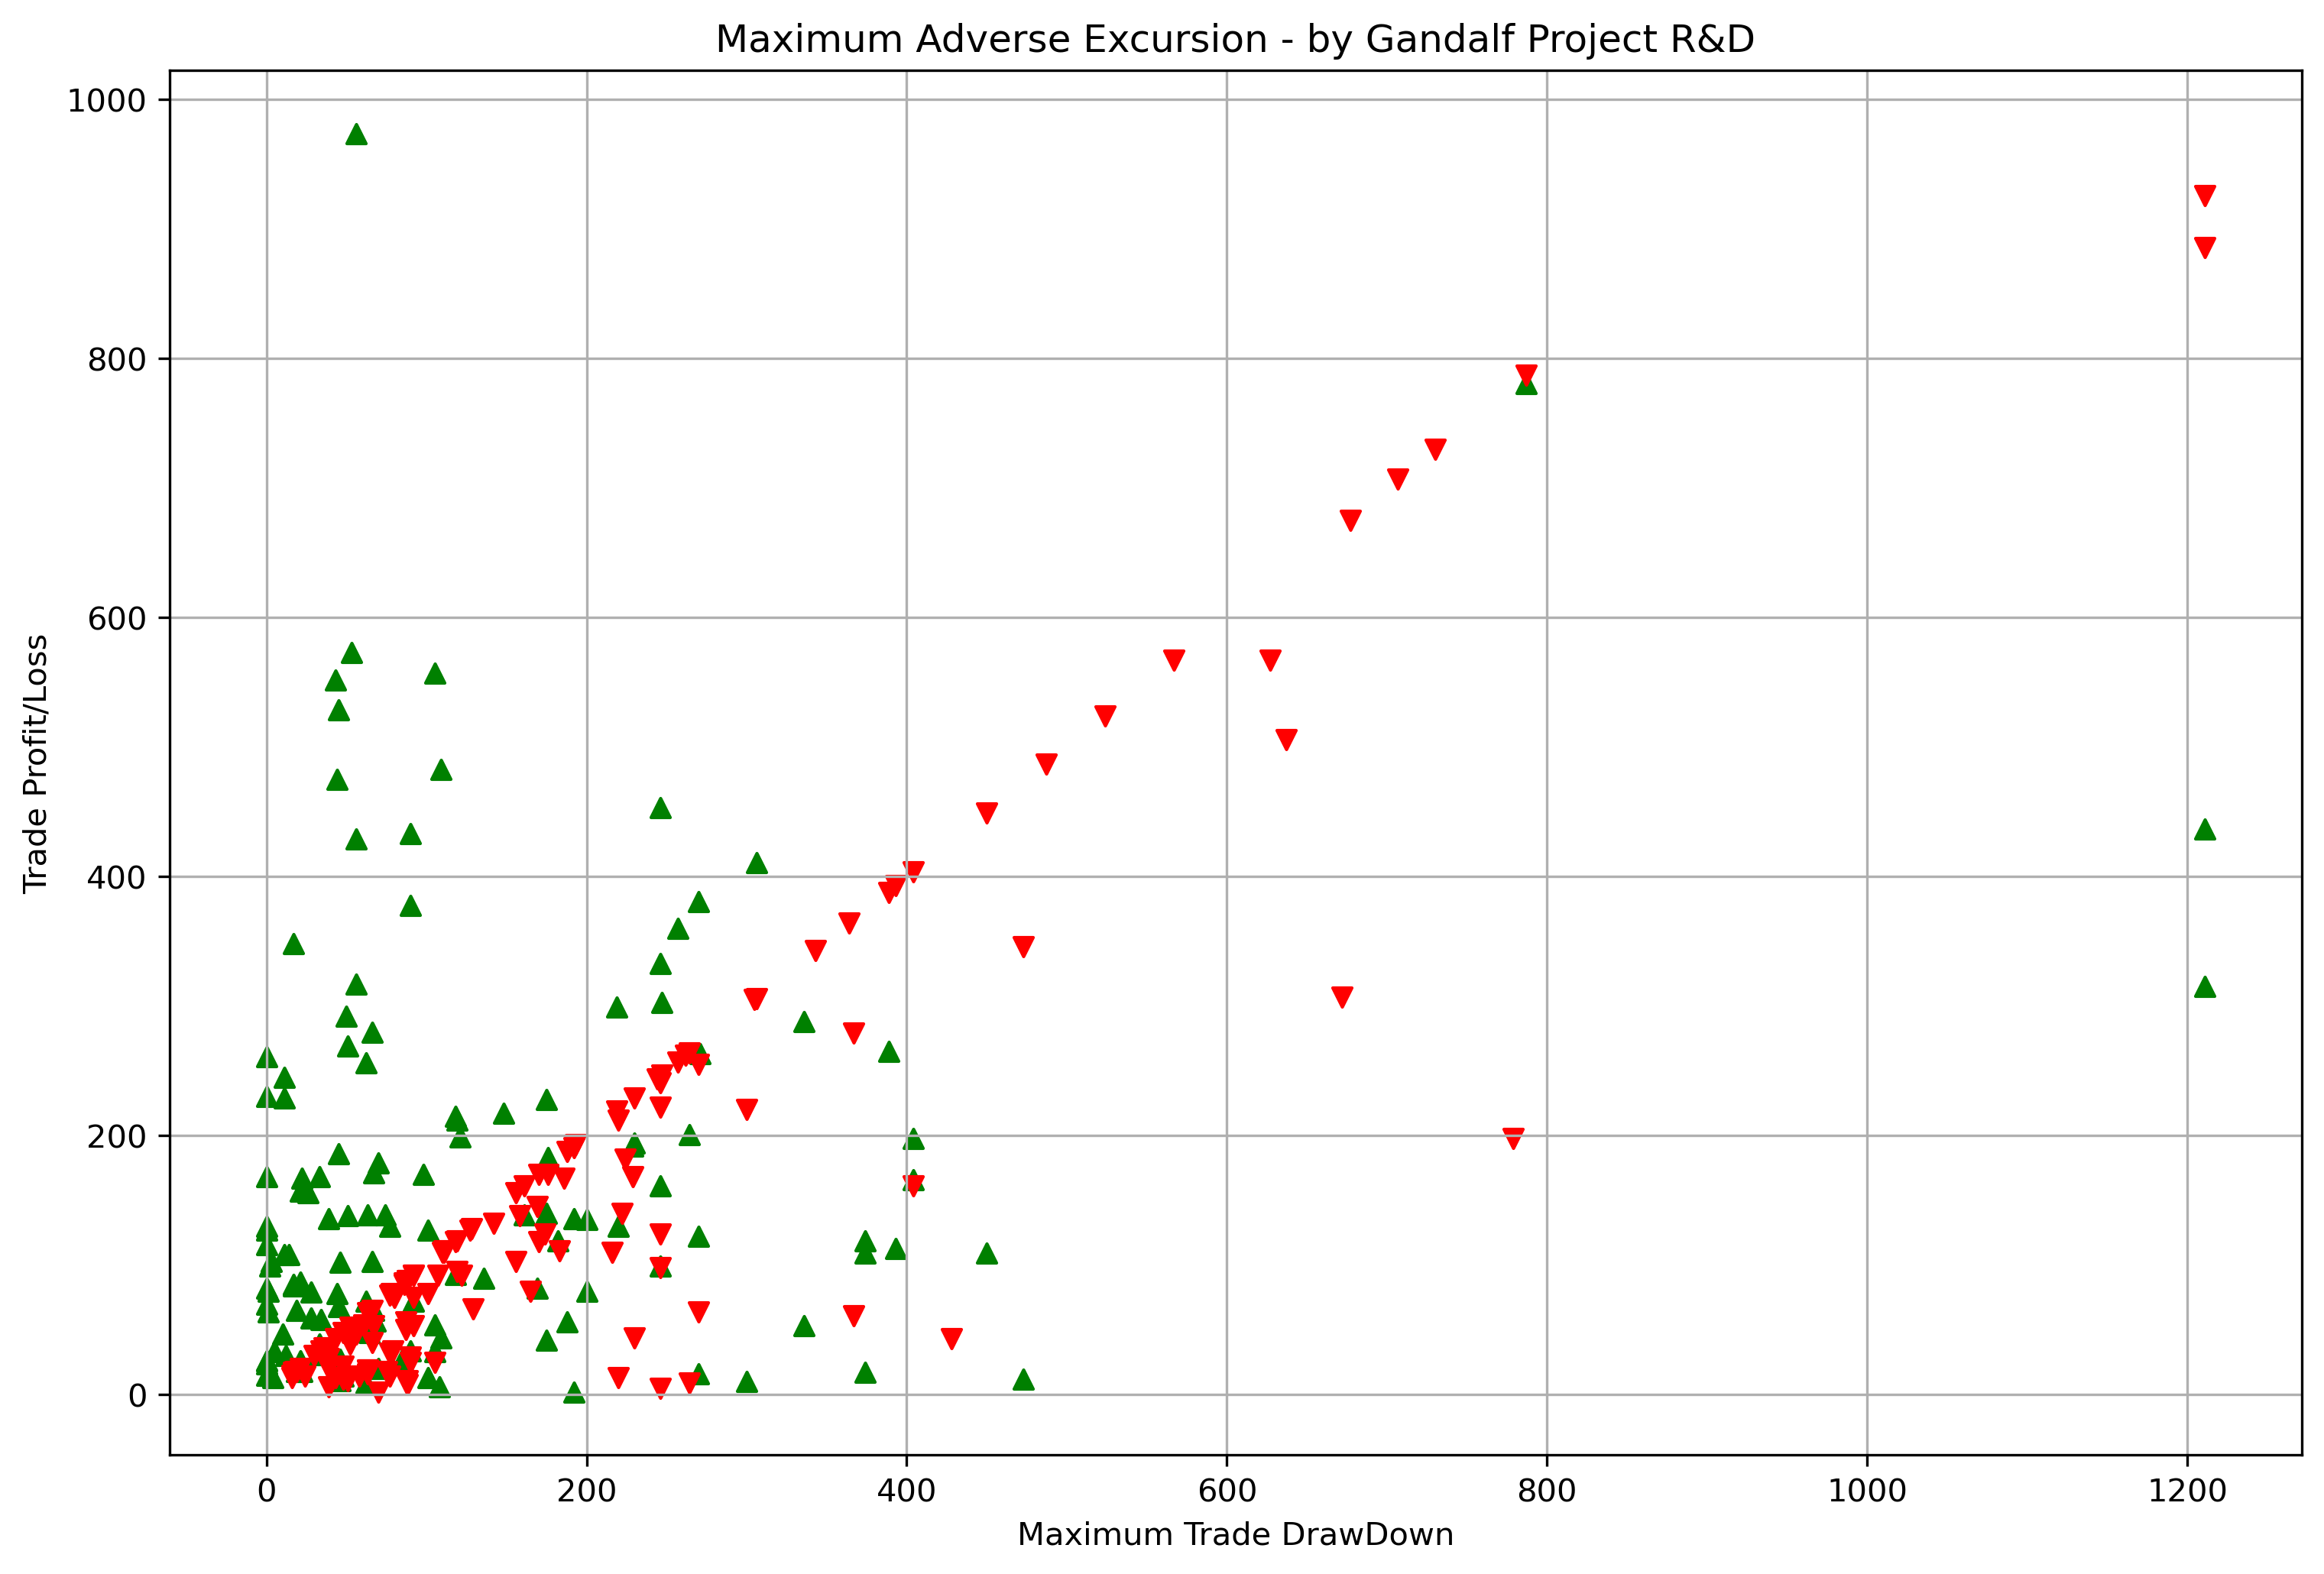

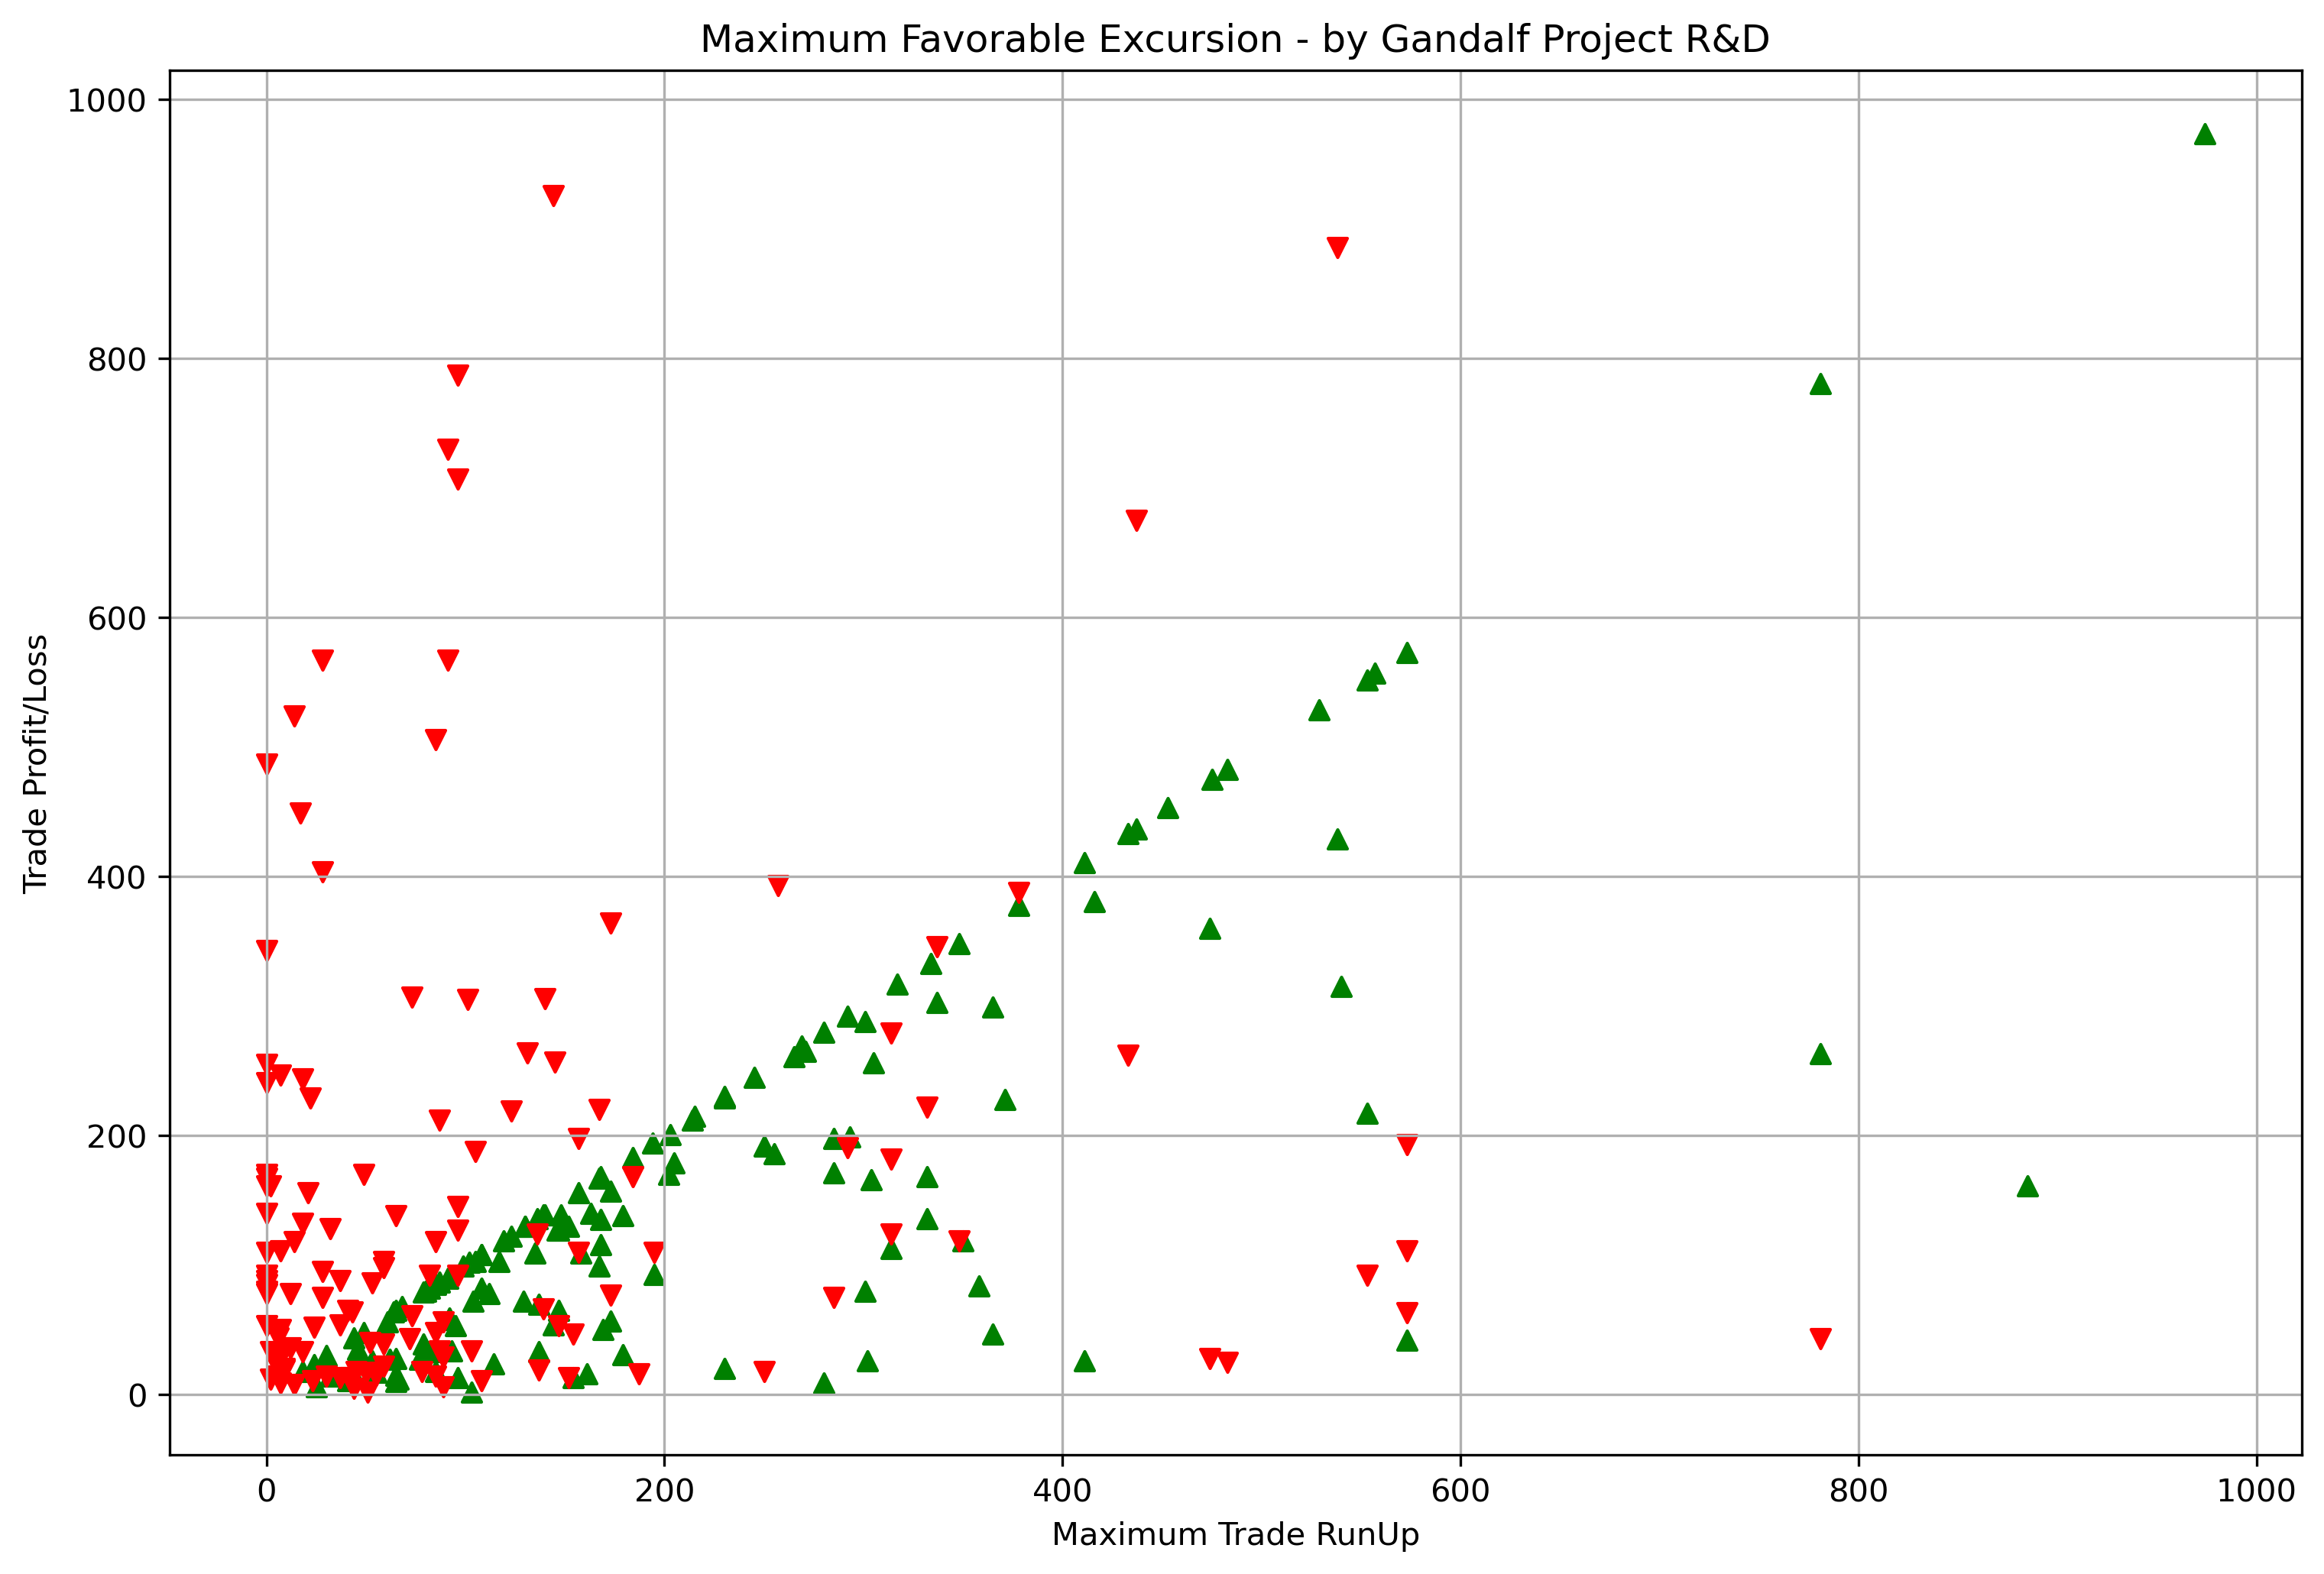

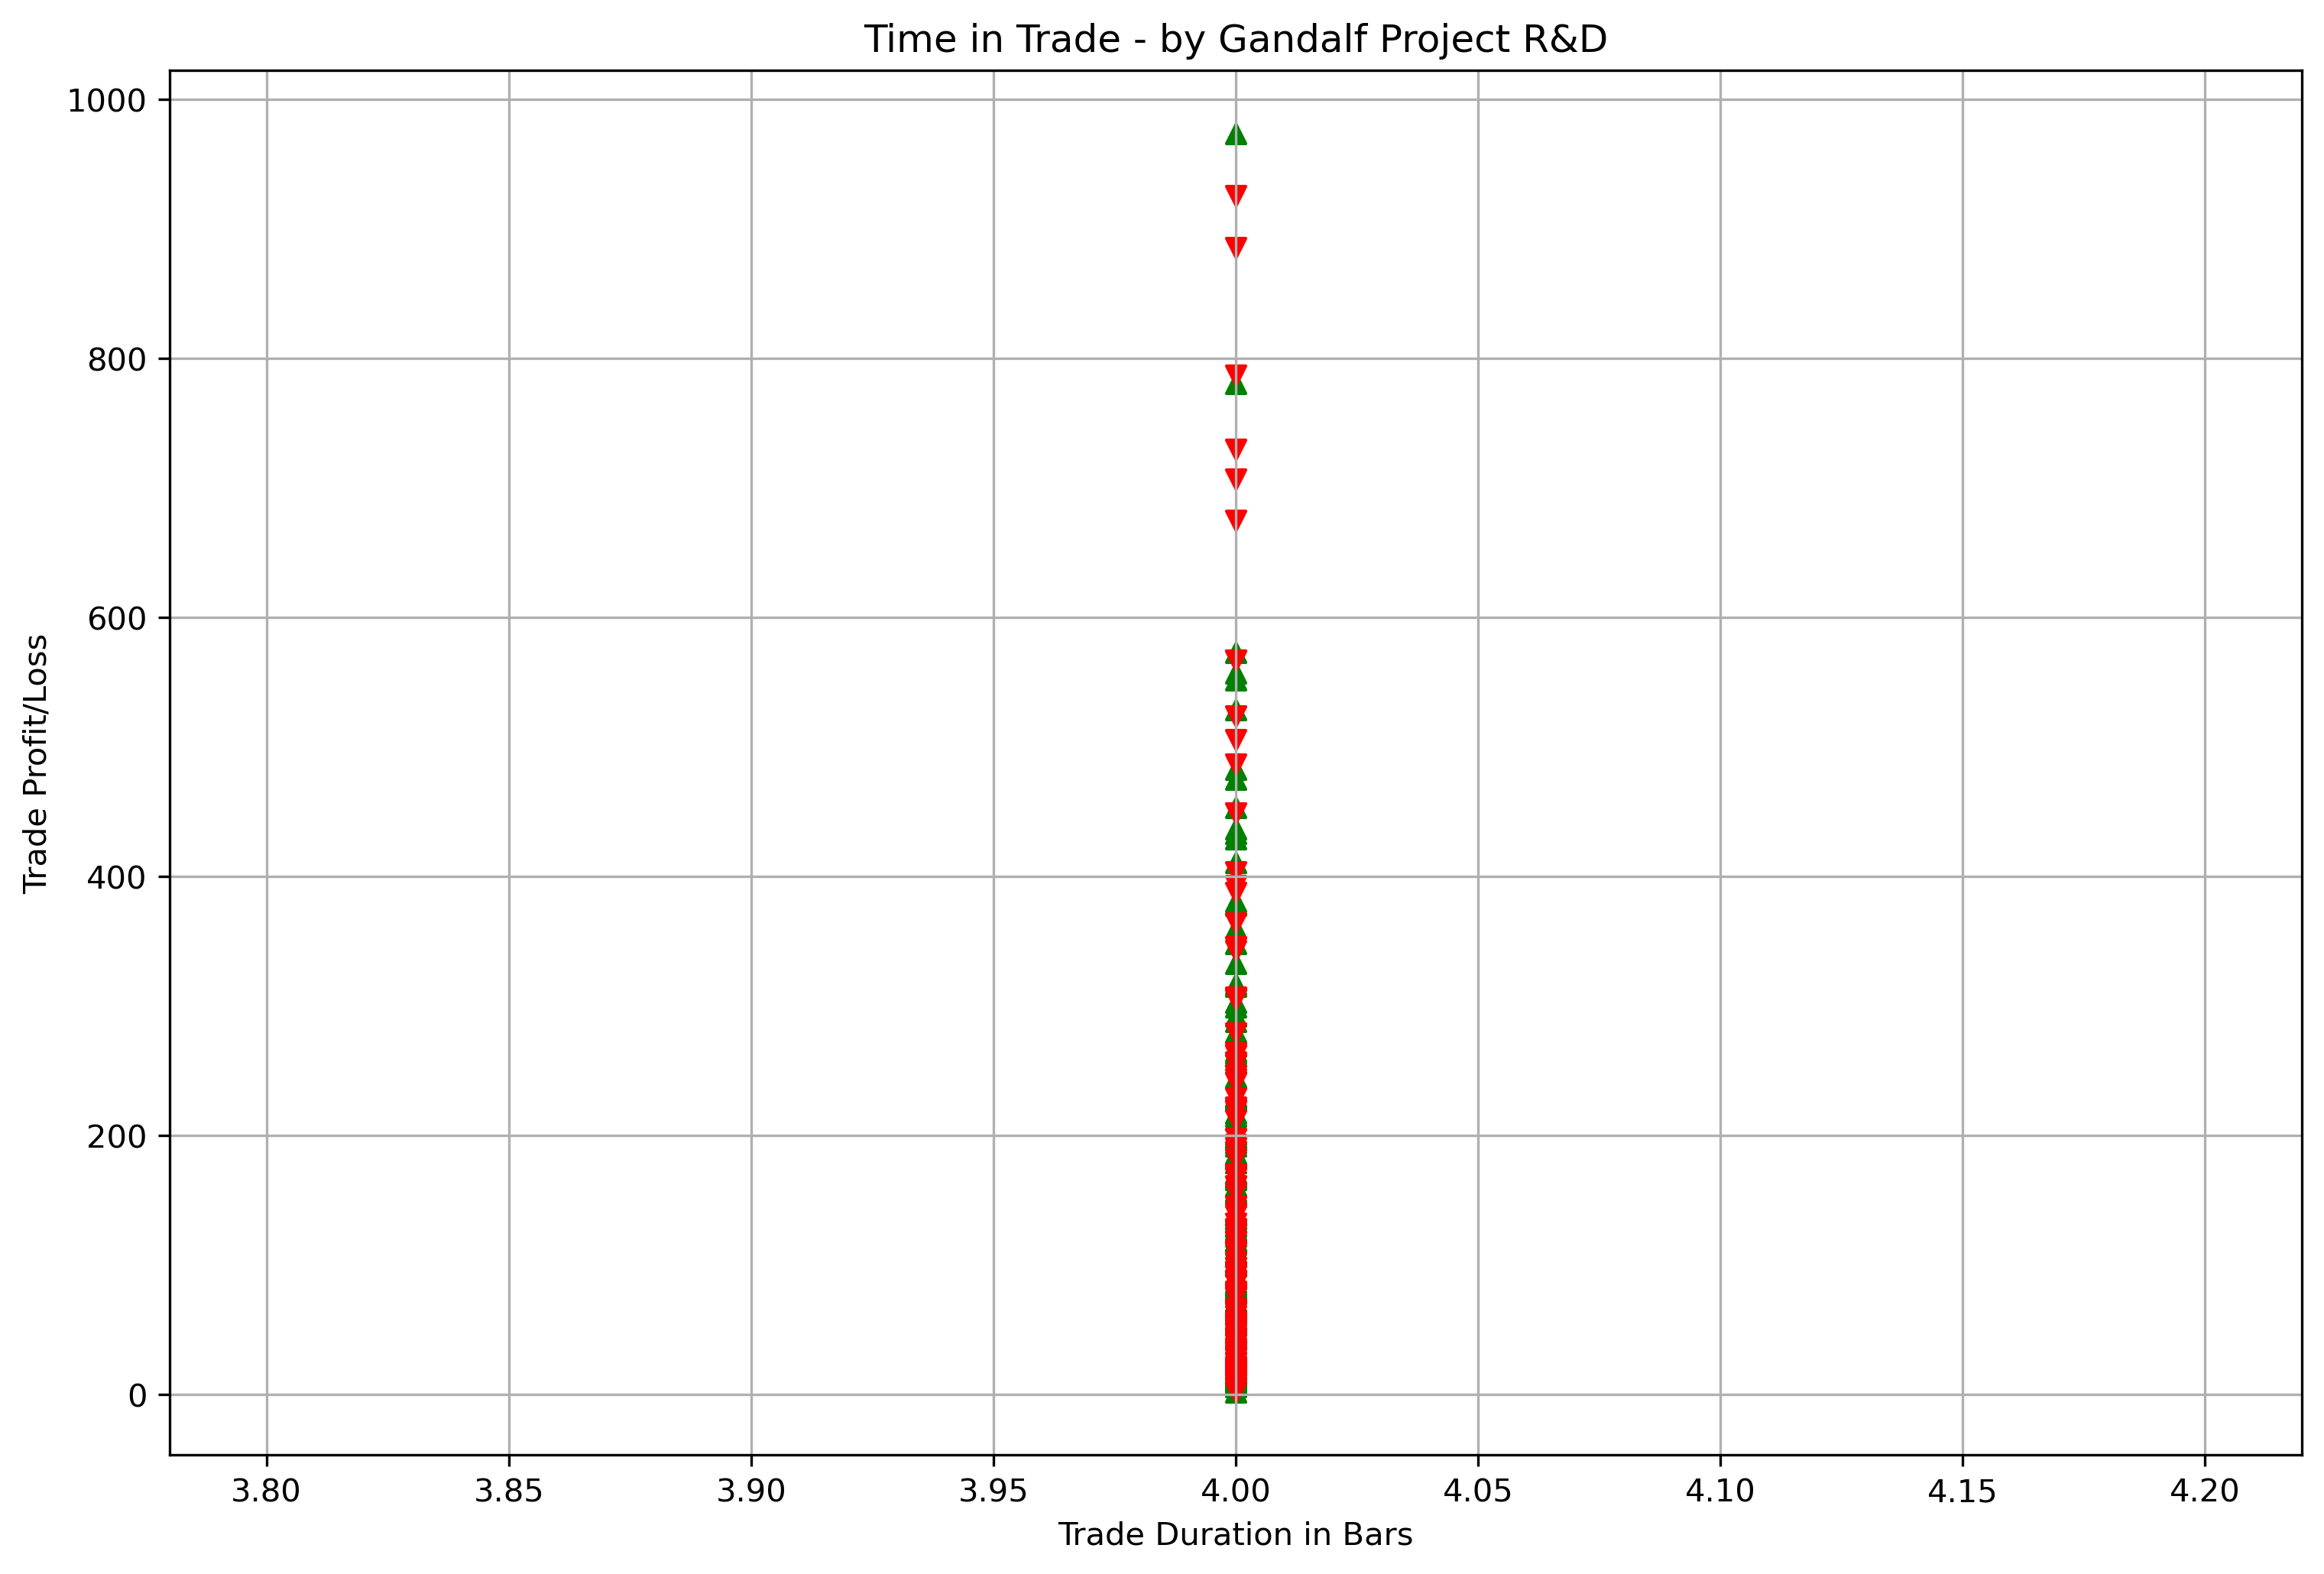

In [187]:
dataset["entry_rule"] = eval(pattern_formula(last_dna)) #eval(dna_formula(last_dna)) #setups(numba.typed.List(last_dna))

NAME = "Tester"

WRITELOG = False

EXIT_ON_ENTRY_BAR = False
CONSECUTIVE_TRADES = True

COSTS_FIXED = 0 #COSTS_FIXED
# 10 for 10 $ for each transaction (2 * fee each operation)
COSTS_VARIABLE = 0.0
# 1.0 for 1% (2 * fee each operation)
COSTS_PERSHARES = 0.0 
# 0.01 for 1 cent for each shares traded (2 * fee each operation)

INSTRUMENT = 2 # 1: equity, 2: future, 3: crypto/forex
TICK = TICK
BIGPOINTVALUE = BIGPOINTVALUE
ORDER_TYPE = "market"
MAX_INTRADAY_OPERATIONS = 100

QUANTITY = 1
MARGIN_PERCENT = 10 # margin to use in capital calculation

TIME_EXIT = TIME_EXIT  # 0 to disable
TIME_EXIT_LOSS = 0  # 0 to disable
TIME_EXIT_GAIN = 0  # 0 to disable

MONEY_STOPLOSS = 0  # 0 to disable
MONEY_TARGET = 0  # 0 to disable

MIN_MONEY_PERCENT_STOPLOSS = 0
PERCENT_STOPLOSS = 0.0  # 0 to disable

MIN_MONEY_PERCENT_TARGET = 0
PERCENT_TARGET = 0.0  # 0 to disable

enter_level = dataset.high

exit_rules_loss = False

exit_rules_gain = False 

target_level = 0 # 0 to disable

stop_level = 0 # 0 to disable

DIRECTION = DIRECTION

enter_rules = dataset["entry_rule"] & (dataset.index.hour>=1) & (dataset.index.hour<=21)

dataset["exit_rule"] = (dataset.index.hour>=21)

exit_rules = dataset["exit_rule"]

tradelist, open_equity, closed_equity, operation_equity = apply_trading_system(dataset.iloc[:], INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                               COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                               ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                               exit_rules, exit_rules_loss, exit_rules_gain,
                                                                               target_level, stop_level,
                                                                               TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                               MONEY_STOPLOSS, MONEY_TARGET, 
                                                                               PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                               PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)

# True: Interactive, False: Static
performance_report(dataset, tradelist, closed_equity, open_equity, 100000, 0, MARGIN_PERCENT, False)

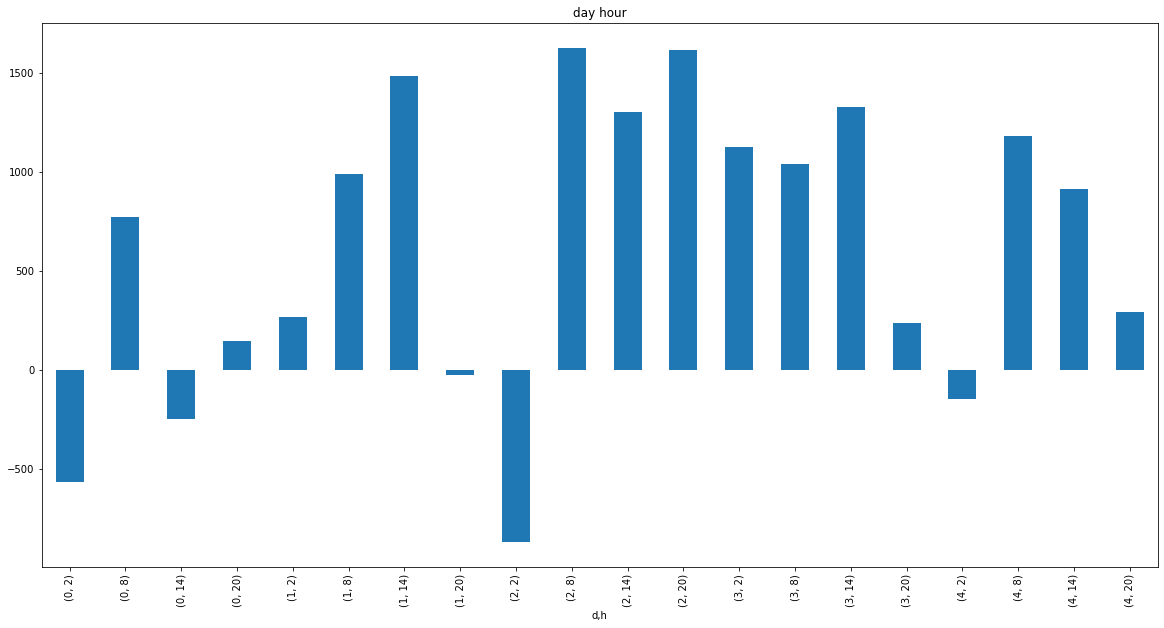

In [173]:

an = tradelist.copy()
an.set_index(["entry_date"],inplace=True)
an["h"]=an.index.hour
an["d"]=an.index.dayofweek
an["d_m"]=an.index.day

an.groupby(["d","h",]).sum().operations.plot.bar(title="day hour",figsize=(20,10))
plt.show()